# data4physics homework

## XP spectra:  
*[how to access Gaia XP spectra]: (https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products#datalink_jntb_get_all_prods)  

## APOGEE labels (Teff, Log g):  
* [labels: APOGEE DR17 catalog]. (https://www.sdss4.org/dr17/irspec/spectro_data/).   
[data model] : (https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStarLite.html)

In [1]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import numpy as np
from scipy import linalg
from dataclasses import dataclass
from scipy.special import gamma, kv
from scipy.interpolate import interp1d

# Read data

In [2]:
import pickle

data_dir = "./"
tr_file  = "ap17_xpcont_train.pickle"
val_file = "ap17_xpcont_validation.pickle"


with open(data_dir+tr_file, 'rb') as f1:
    data_tr = pickle.load(f1)

with open(data_dir+val_file, 'rb') as f2:
    data_val = pickle.load(f2)
    
    
print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys())

print("array shape of traing set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])

Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels'])
array shape of traing set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


### note: labels are n*2, the first column is TEFF, the second is Log g.

In [3]:
bp_tr, rp_tr = data_tr['bp_coef'], data_tr['rp_coef']

teff_tr = data_tr['labels'][:,0]


# Data visualization: take training set as example  
## show labels

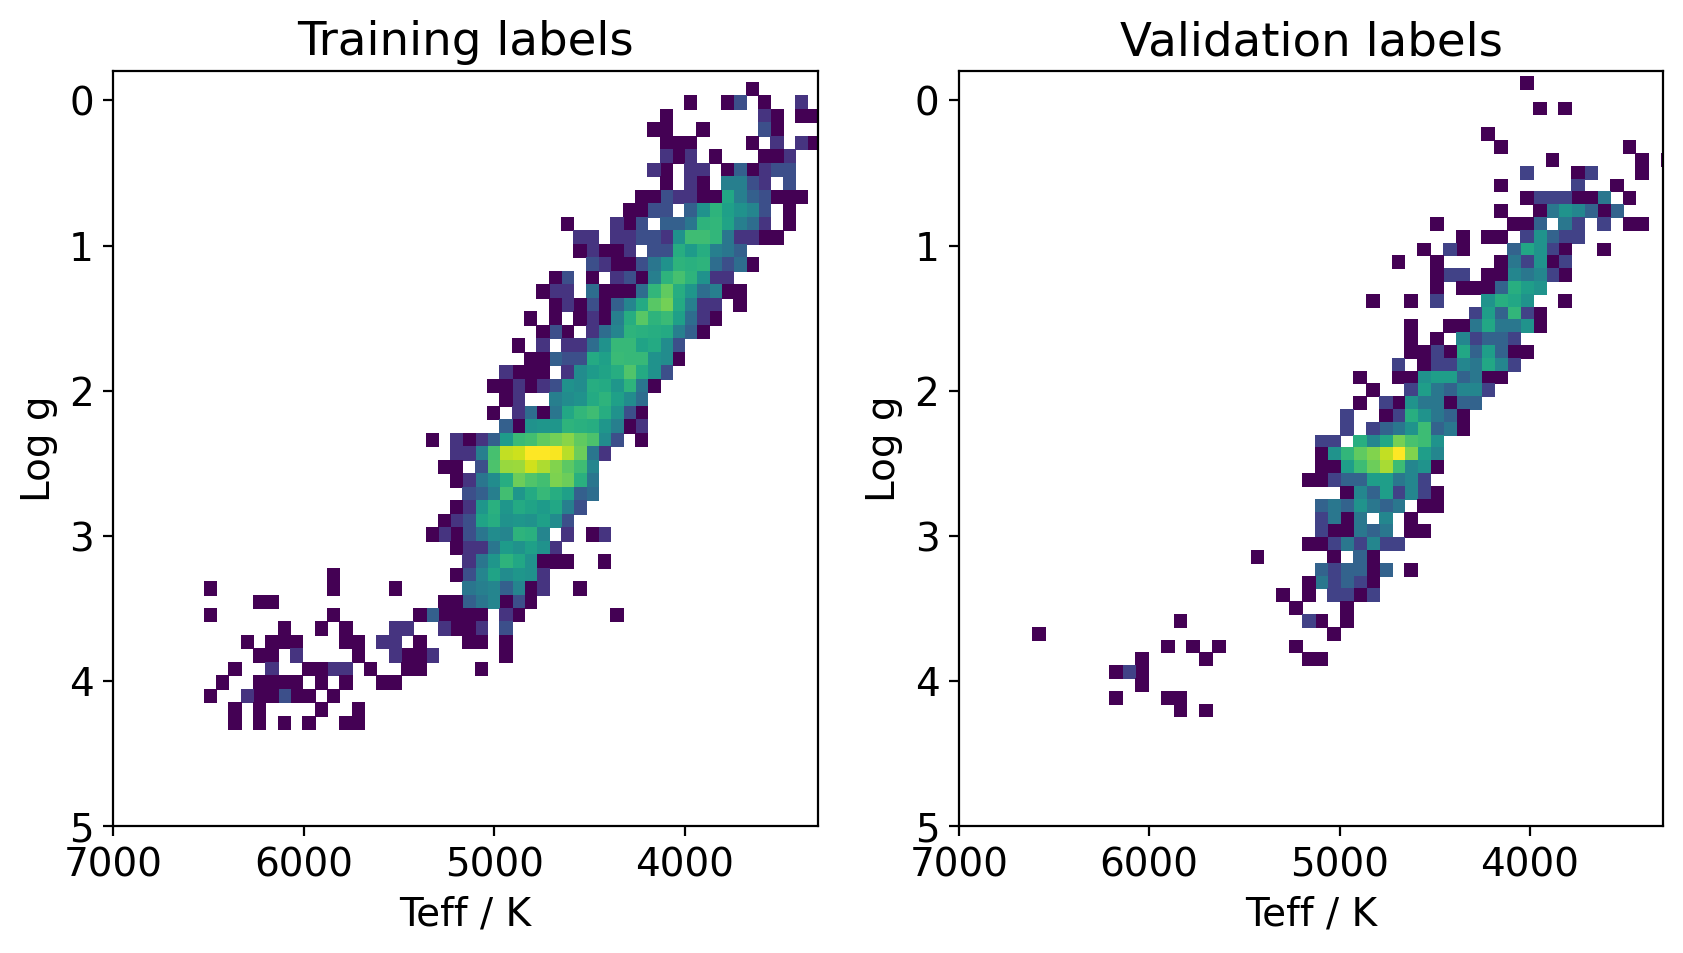

In [4]:
# Teff - Log g plot

fig, axs = plt.subplots(1,2,figsize=(10,5))


for i, ax in enumerate(axs.ravel()):

    
    if i==0:
        ax.hist2d(
        data_tr['labels'][:,0], data_tr['labels'][:,1],
        bins=50, norm=LogNorm());
        ax.set_title("Training labels");
    else:
        ax.hist2d(
        data_val['labels'][:,0], data_val['labels'][:,1],
        bins=50, norm=LogNorm());
        ax.set_title("Validation labels");
        
    ax.set_xlim([7000, 3300]);
    ax.set_ylim([5, -0.2]);
    ax.set_xlabel("Teff / K");
    ax.set_ylabel("Log g");

# show bp and rp coefficients

## first eight coefficients color coded by Logg

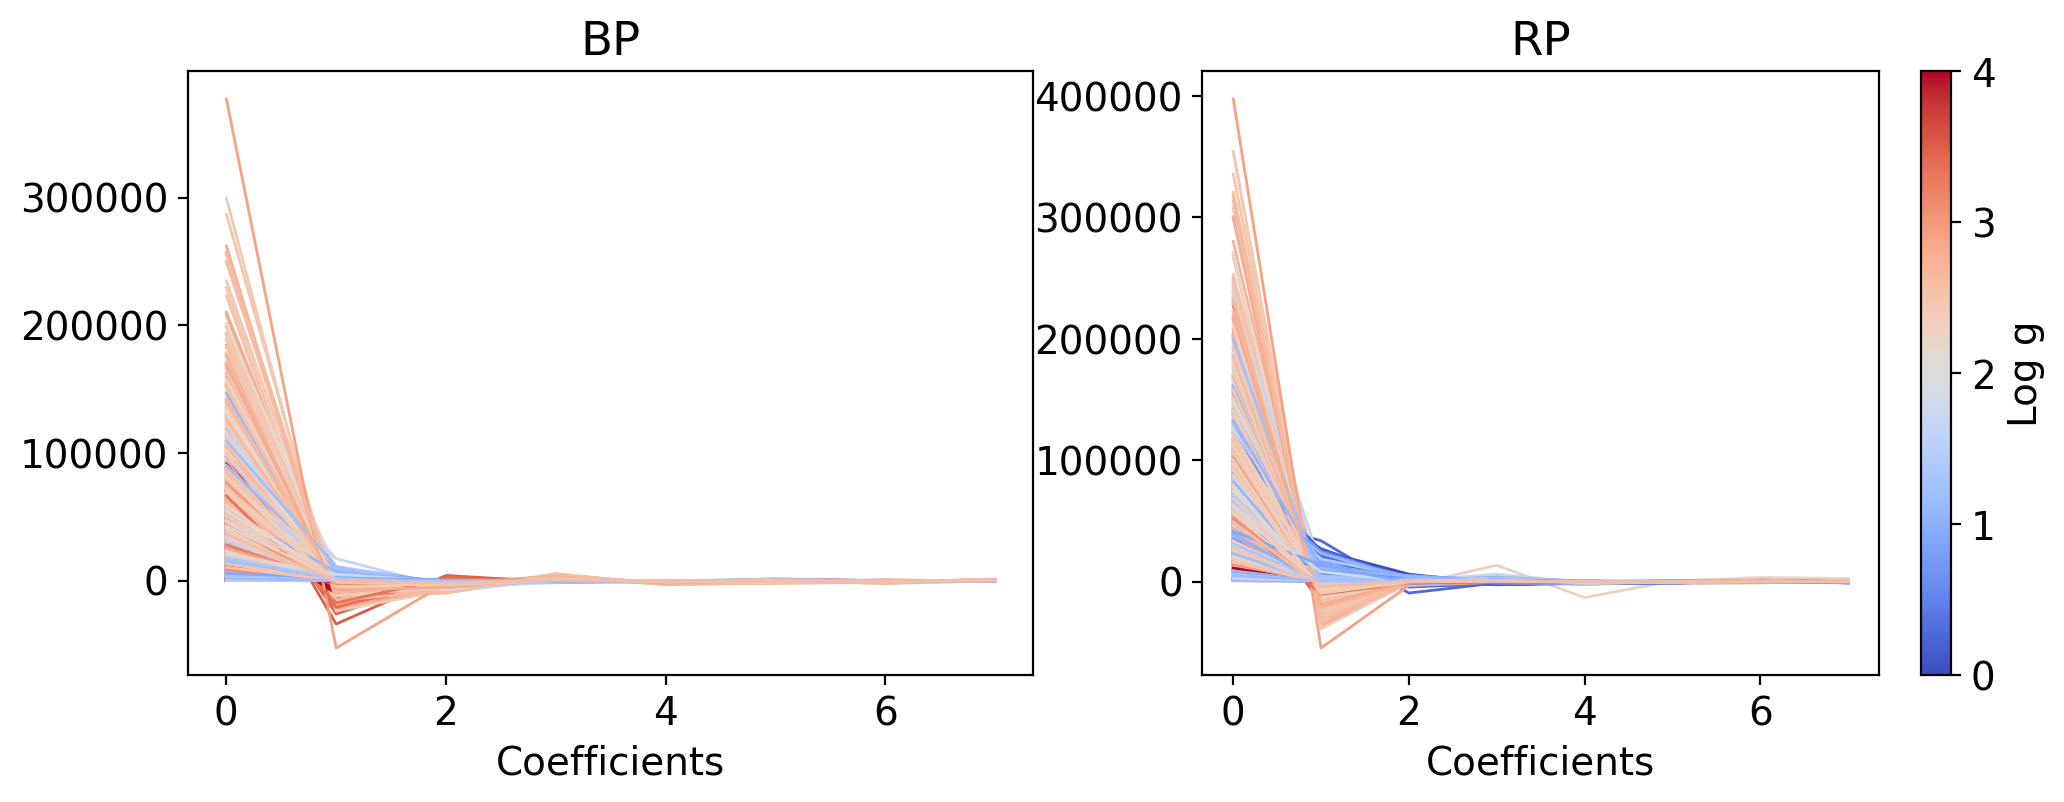

In [5]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axs.ravel()

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0,vmax=4)
colors_train_logg = [cmap(norm(_)) for _ in data_tr['labels'][:,1]]

for i,idx in enumerate(range(len(data_tr['labels']))):
    
    xx = np.arange(8)
    ax1.plot(
        xx, data_tr['bp_coef'][idx,:8],lw=1,
        c=colors_train_logg[i]
    )
    ax2.plot(
        xx, data_tr['rp_coef'][idx,:8],lw=1,
        c=colors_train_logg[i]
    )
    
ax1.set_title("BP");
ax2.set_title("RP");

for ax in axs.ravel():
    ax.set_xlabel("index");
    ax.set_xlabel("Coefficients");
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
clb = plt.colorbar(sm, label="Log g")

## first eight coefficients color coded by Teff

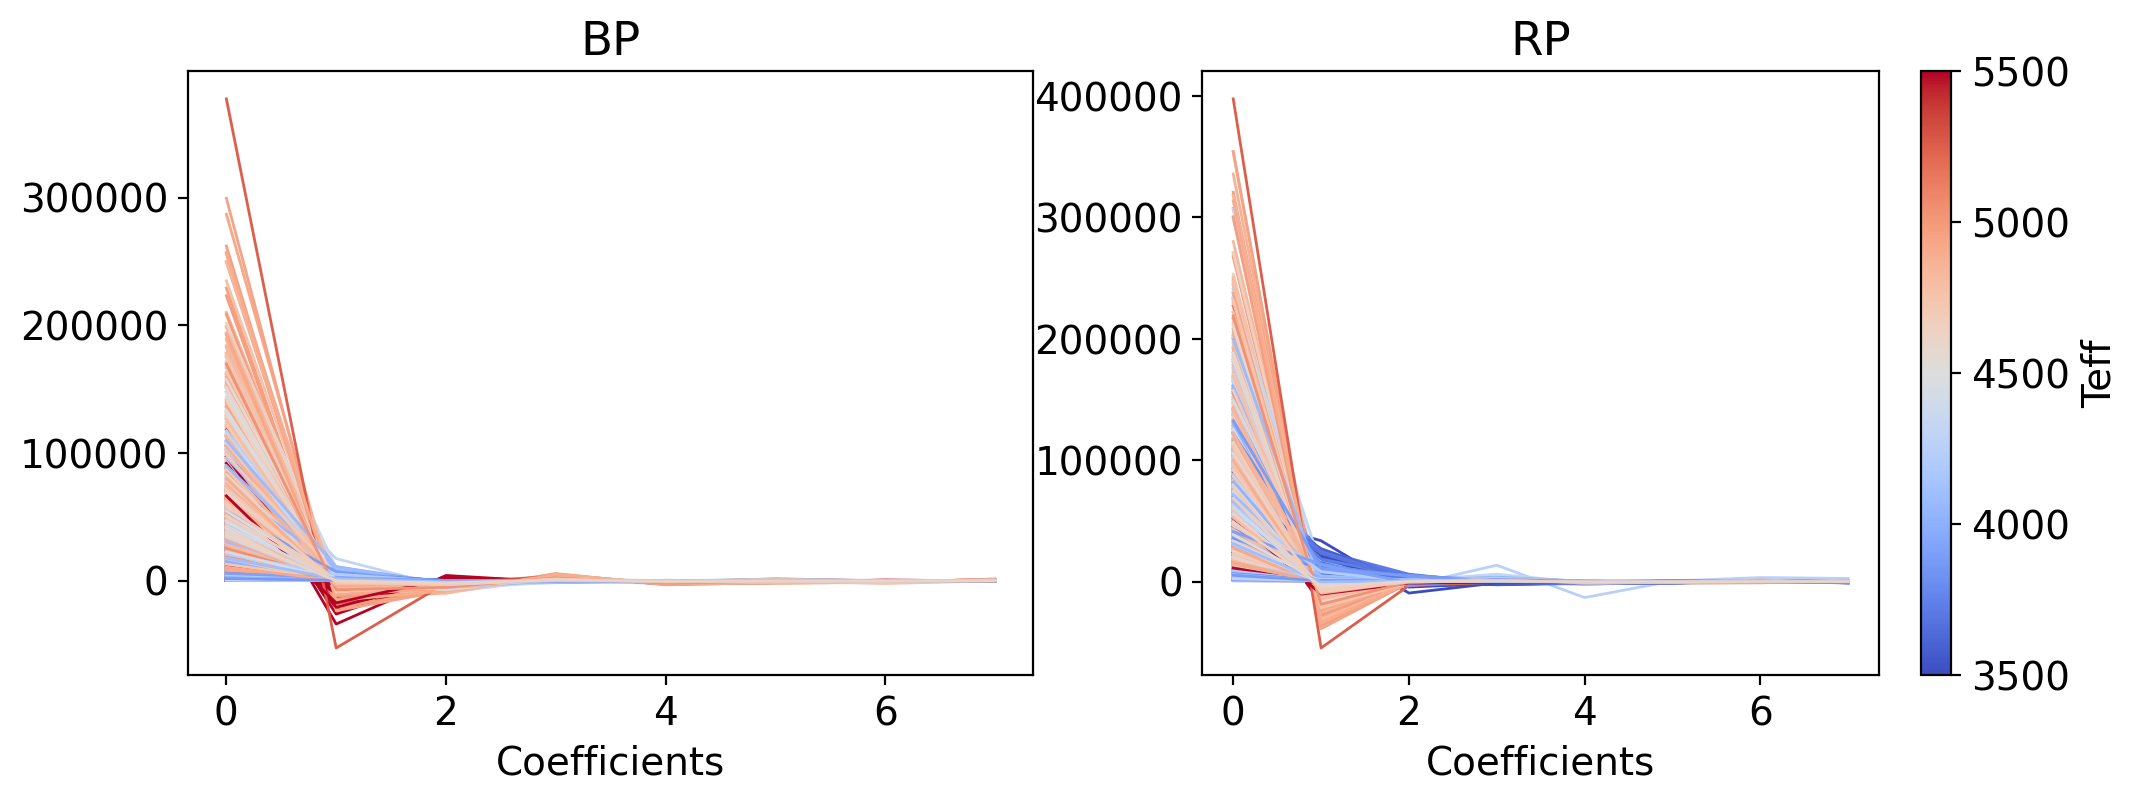

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axs.ravel()

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=3500, vmax=5500)
colors_train_teff = [cmap(norm(_)) for _ in data_tr['labels'][:,0]]

for i,idx in enumerate(range(len(data_tr['labels']))):
    
    xx = np.arange(8)
    ax1.plot(
        xx, data_tr['bp_coef'][idx,:8],lw=1,
        c=colors_train_teff[i]
    )
    ax2.plot(
        xx, data_tr['rp_coef'][idx,:8],lw=1,
        c=colors_train_teff[i]
    )
    
ax1.set_title("BP");
ax2.set_title("RP");

for ax in axs.ravel():
    ax.set_xlabel("index");
    ax.set_xlabel("Coefficients");
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
clb = plt.colorbar(sm, label="Teff")

#### Problem 1: Take the Gaia XP data given to you by Jiadong Li. It consists of a set of ESA Gaia Mission BP/RP spectral coefficients, and a set of labels from SDSS-IV APOGEE. These are real data, people, and a real problem. Use linear regression to learn a function that takes as input the BP and RP spectral coefficients and delivers as output the label TEFF, which is the effective temperature of the stars. Instead of using the BP/RP coefficients right out of the box, consider dividing all BP & RP coefficients by the first (zeroth) component of the RP coefficients. Don’t forget to include the number 1 as a regressor (the constant term). Train on the training set and use the validation set to assess your accuracy (RMS maybe or median absolute deviation).

Here, the coefficients are the features (Xs) and the effective temperatures are the labels (Ys). We are trying to find some function $Y(X)$ using linear regression.

Linear regression is performed by minimizing the loss

### $\mathcal{L} = ||Y-X^T\theta||_2^2$.

The double bar sub 2 exp 2 notation denotes the L2 norm squared of the argument.

The optimal parameters under linear regression are

### $\hat{\theta} = (X^TX)^{-1}X^TY$ 

such that the predicted labels are

### $\hat{Y_*} = X_*^T\hat{\theta}$

where star denotes test features/labels.

To add ridge regularization, 

### $\mathcal{L} = ||Y-X^T\theta||_2^2+\Lambda||\theta||_2^2$

where $\Lambda$ is some constant imposing a penalty on large parameters. 

The resulting optimal parameters are

### $\hat{\theta} = (X^TX+\Lambda I_p)^{-1}X^TY$ 

where $I_p$ is a $p$x$p$ identity matrix where $p$ is the number of parameters.

In the below, I divide all coefficients by the maximum coefficient value so that the Xs are "normalized". I did this because that is what I would normally do when doing machine learning on some data (such as image data). 

I then do the linear regression using the linear and constant term only. I also check whether the regression is improved by including a ridge regularization term. To evaluate whether the linear regression is "good", I train a null linear regression model on data drawn from the uniform distribution $\mathcal{U}[\min(Y_{train}), \max(Y_{train})]$.

Ridge regularization massively improves the linear regression. Without the regularization, the linear regression model is no better than the model trained on the pure noise data.



In [7]:
bp = data_tr['bp_coef']
rp = data_tr['rp_coef']
teff = data_tr['labels'][:,0]
data_xs = np.dstack((bp, rp))
data_xs /= np.max(data_xs)
data_ys = teff

bp_val = data_val['bp_coef']
rp_val = data_val['rp_coef']
teff_val = data_val['labels'][:,0]
data_xs_val = np.dstack((bp_val, rp_val))
data_xs_val /= np.max(data_xs_val)
data_ys_val = teff_val

In [8]:
@dataclass
class LinearRegression1:
    data_xs: np.ndarray
    data_ys: np.ndarray
    data_xs_val: np.ndarray
    data_ys_val: np.ndarray   

    def prepare_X(self, xs):
        ones = np.ones((xs.shape))
        X = np.stack((xs, ones), axis=3)
        return X
    
    def fit(self, xs, ys): 
        X = self.prepare_X(xs)
        Y = np.expand_dims(ys, 1)
        A = np.tensordot(X.T, X, axes=((3,2,1), (0,1,2)))
        B = X.T@Y

        #solve
        Z = linalg.solve(A, B)
        return X,Z

    def fit_ridge(self, xs, ys):
        X = self.prepare_X(xs)
        Y = np.expand_dims(ys, 1)
        A = np.tensordot(X.T, X, axes=((3,2,1), (0,1,2)))
        A += 1000*np.identity(A.shape[0])
        B = X.T@Y

        #solve
        Z = linalg.solve(A, B)
        return X,Z
   
    def plot(self, noise_on = False, ridge = False):
        if noise_on == False:
            fig = plt.figure()
            if ridge ==  True:
                X, Z = self.fit_ridge(self.data_xs, self.data_ys)
            else:
                X, Z = self.fit(self.data_xs, self.data_ys)
            Ypred = np.tensordot(X, Z, axes=((3,2,1), (0,1,2)))
            Ytrue = np.expand_dims(self.data_ys, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'TRAIN: mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
            fig = plt.figure()
            X  = self.prepare_X(self.data_xs_val)
            Ypred = np.tensordot(X, Z, axes=((3,2,1), (0,1,2)))
            Ytrue = np.expand_dims(self.data_ys_val, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'VAL: mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
        if noise_on == True:
            fig = plt.figure()
            ys = np.random.uniform(np.min(self.data_ys), np.max(self.data_ys),self.data_ys.shape)
            if ridge == True:
                X, Z = self.fit_ridge(self.data_xs, ys)
            else:
                X, Z = self.fit(self.data_xs, ys)
            Ypred = np.tensordot(X, Z, axes=((3,2,1), (0,1,2)))
            Ytrue = np.expand_dims(ys, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'TRAIN (NOISY FIT): mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
            fig = plt.figure()
            X  = self.prepare_X(self.data_xs_val)
            Ypred = np.tensordot(X, Z, axes=((3,2,1), (0,1,2)))
            Ytrue = np.expand_dims(self.data_ys_val, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'VAL (NOISY FIT): mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')


In [9]:
Model1 = LinearRegression1(data_xs, data_ys, data_xs_val, data_ys_val)

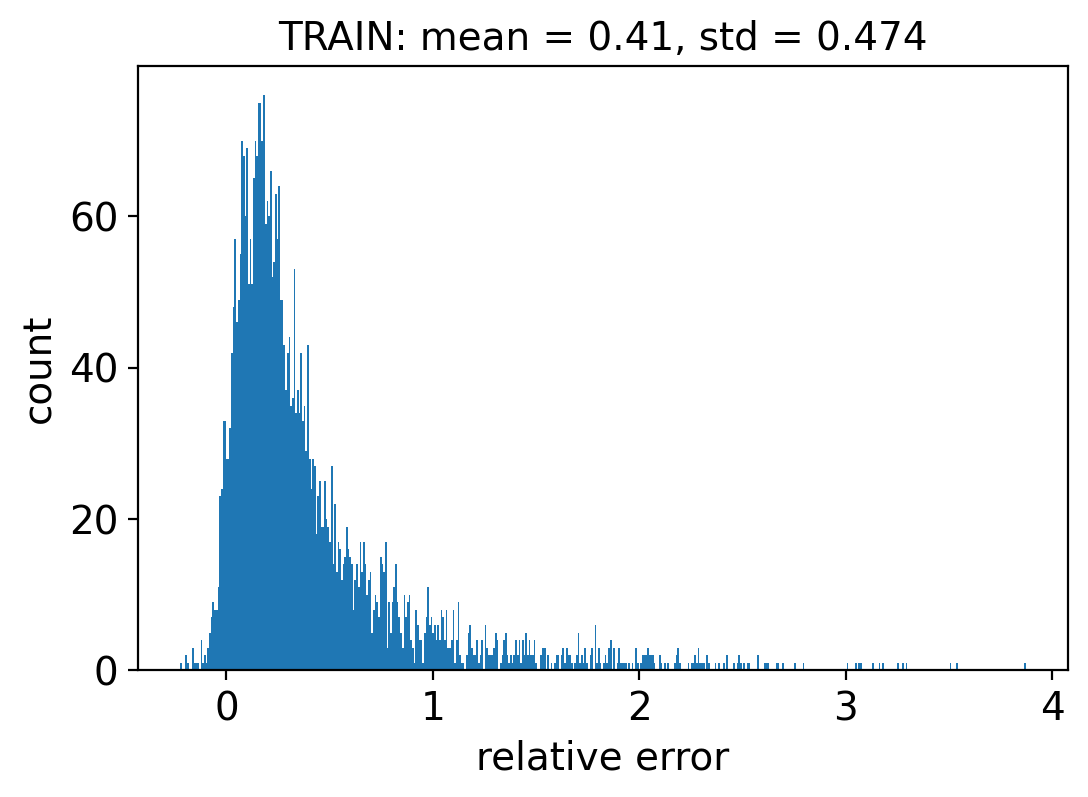

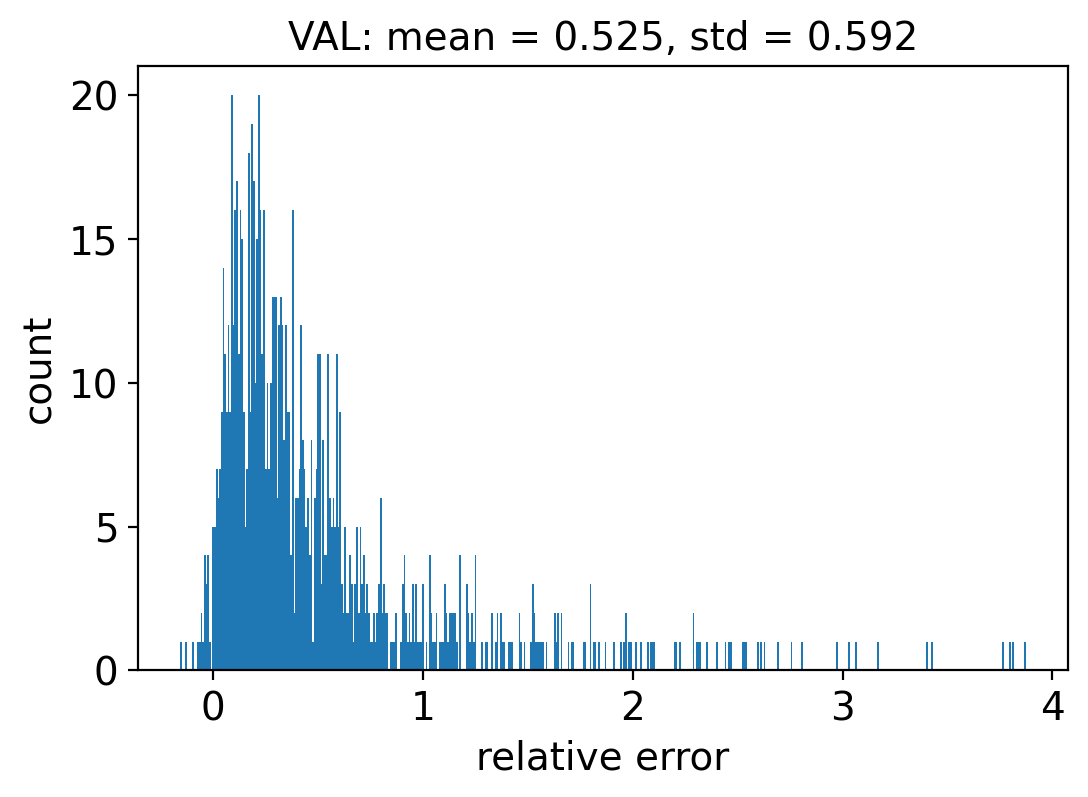

In [10]:
Model1.plot(noise_on = False, ridge = False)

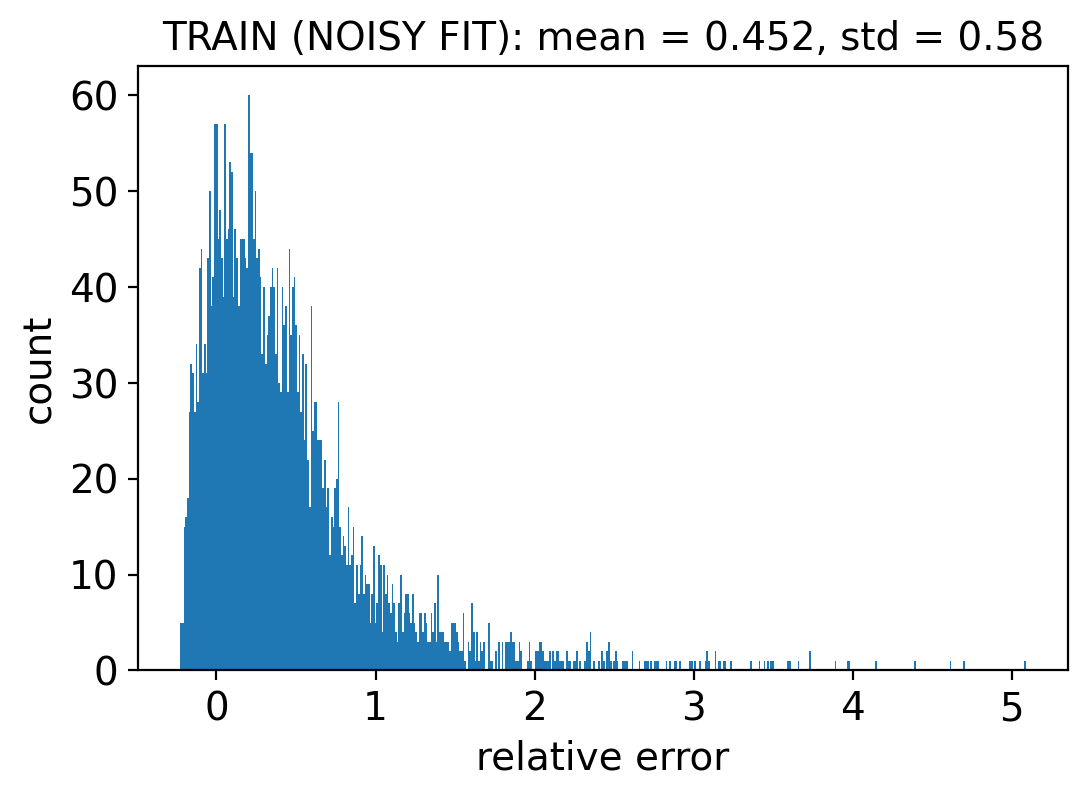

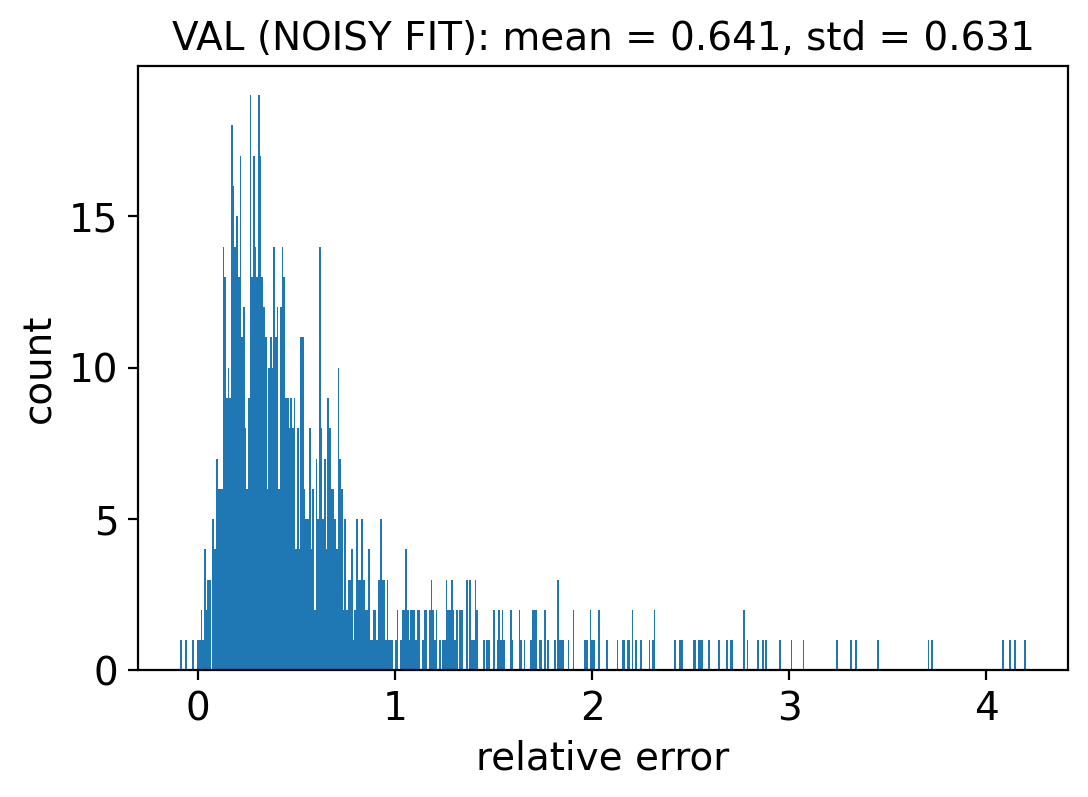

In [11]:
Model1.plot(noise_on = True, ridge = False)

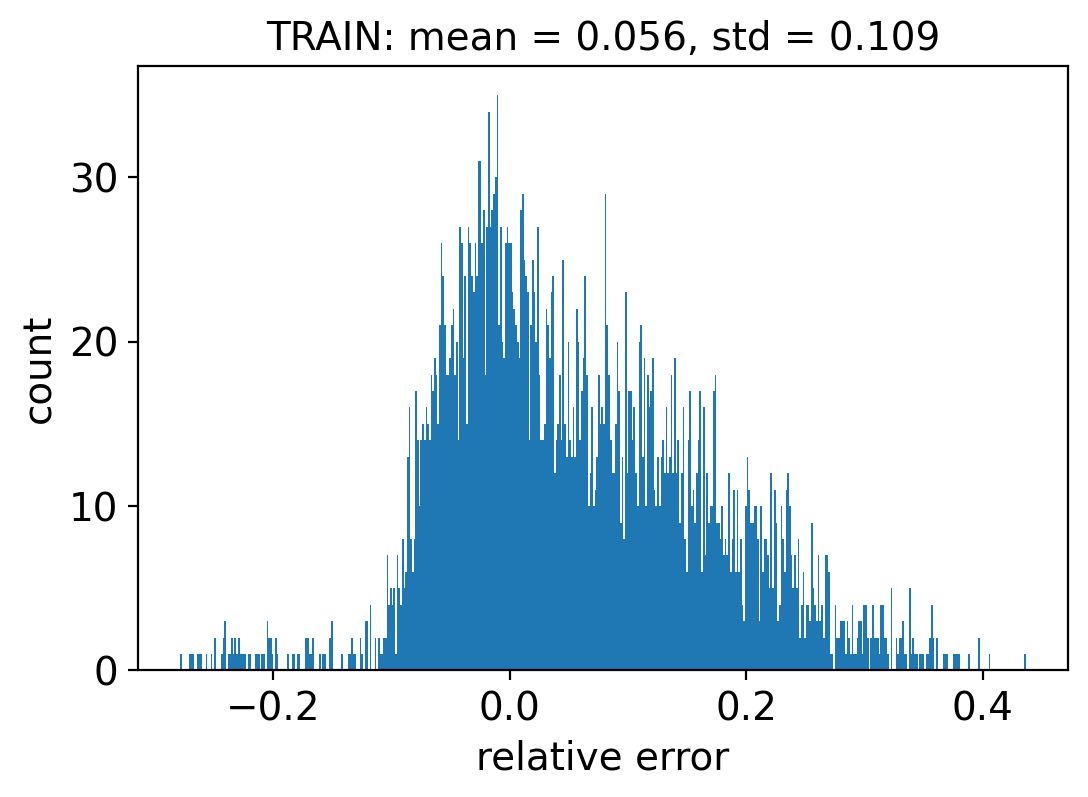

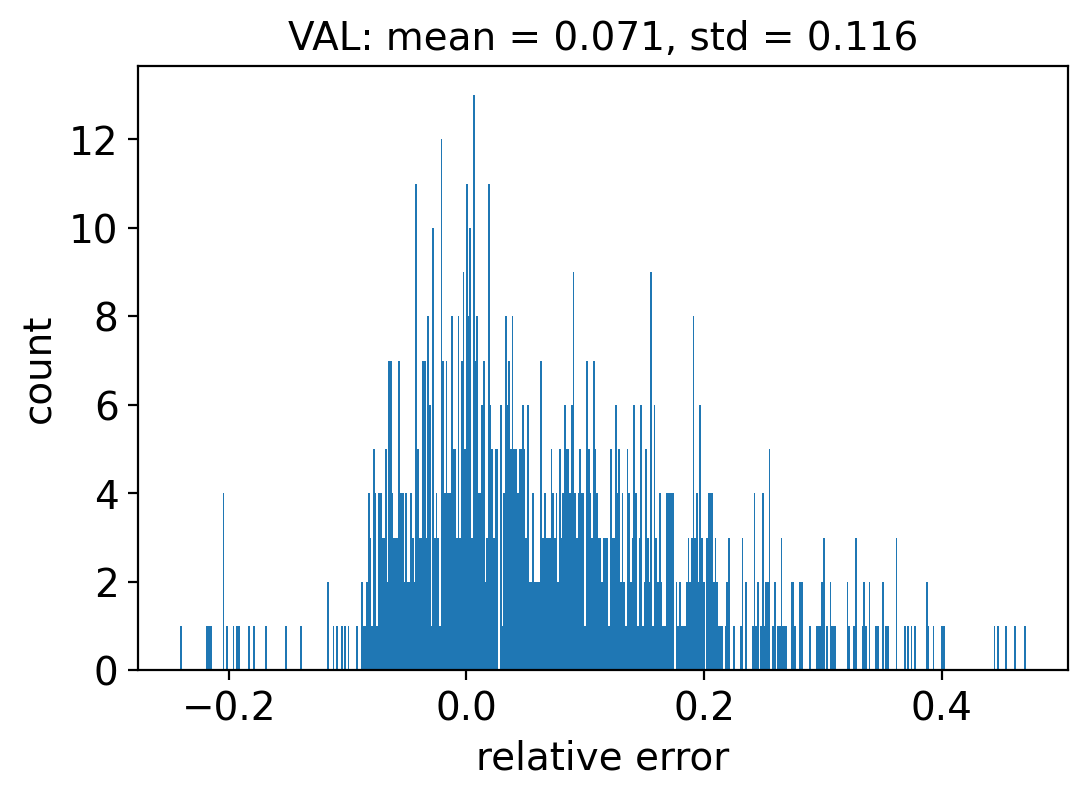

In [12]:
Model1.plot(noise_on = False, ridge = True)

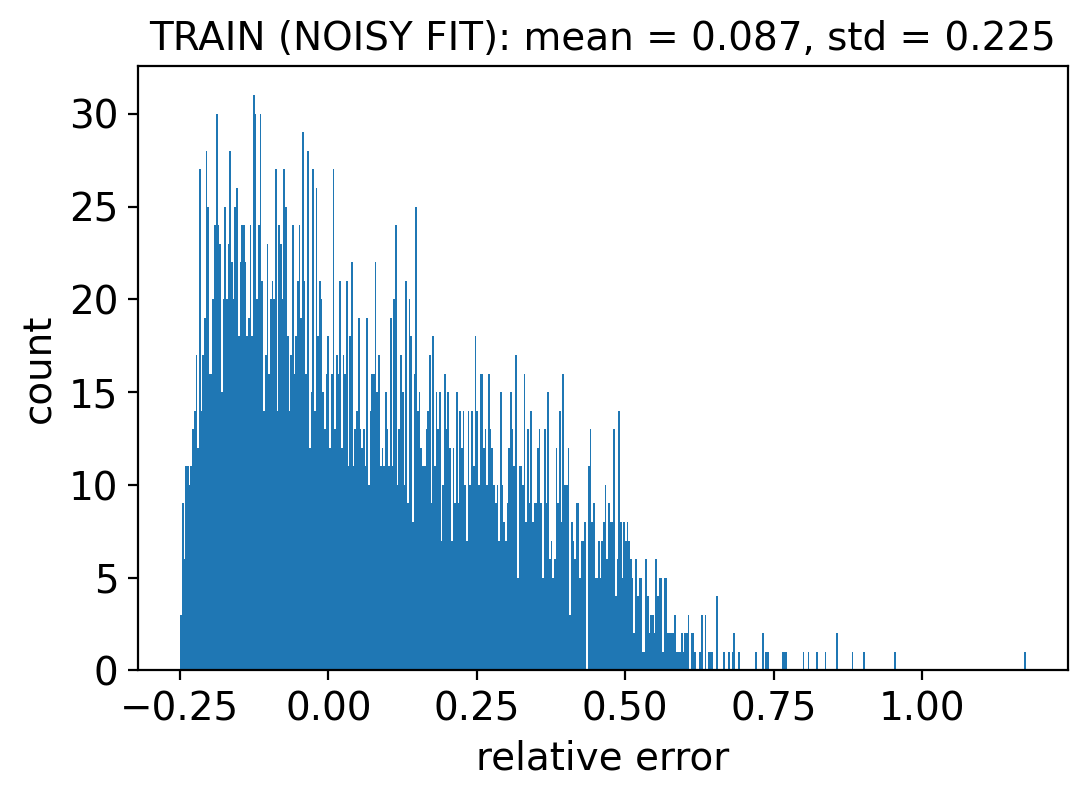

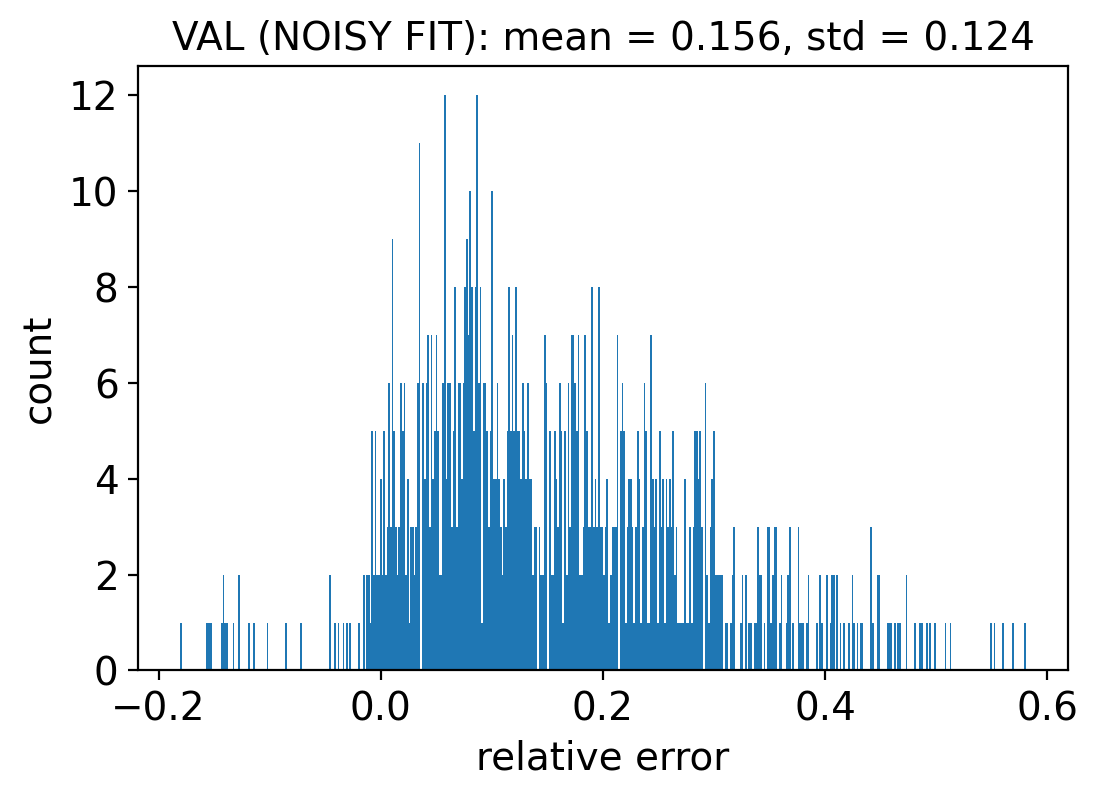

In [13]:
Model1.plot(noise_on = True, ridge = True)

#### Problem 2: Now consider only the RP spectral coefficients. Make a linear model to predict TEFF. Then make all quadratic combinations of the RP coefficients and make a linear model of the linear and quadratic combinations to predict TEFF. Can you afford to do cubic too? Once again, divide the coefficients by RP[0] to start. Once again, don’t forget to include the constant term. Train on the training set and use the validation set to assess your accuracy.

I follow the same procedure as above, but use only RP spectral coefficients. Next, I include all linear and quadratic combinations of the coefficients. It looks like RP alone can do as good of a job as both RP and BP when predicting Teff. Additionally, adding all quadratic combinations does not seem to increase prediction quality much. Again, the regularization is key to acheiving predictions better than those of the null model.

In [14]:
bp = data_tr['bp_coef']
rp = data_tr['rp_coef']
teff = data_tr['labels'][:,0]
data_xs = rp #np.dstack((bp, rp))
data_xs /= np.max(data_xs)
data_ys = teff

bp_val = data_val['bp_coef']
rp_val = data_val['rp_coef']
teff_val = data_val['labels'][:,0]
data_xs_val = rp_val #np.dstack((bp, rp))
data_xs_val /= np.max(data_xs_val)
data_ys_val = teff_val

In [15]:
@dataclass
class LinearRegression2:
    data_xs: np.ndarray
    data_ys: np.ndarray
    data_xs_val: np.ndarray
    data_ys_val: np.ndarray   

    def prepare_X(self, xs):
        ones = np.ones((xs.shape))
        X = np.stack((xs, ones), axis=2)
        return X
    
    def fit(self, xs, ys):
        X = self.prepare_X(xs)
        Y = np.expand_dims(ys, 1)
        A = np.tensordot(X.T, X, axes=((2,1), (0,1)))
        B = X.T@Y

        #solve
        Z = linalg.solve(A, B)
        return X,Z
    
    def fit_ridge(self, xs, ys):
        X = self.prepare_X(xs)
        Y = np.expand_dims(ys, 1)
        A = np.tensordot(X.T, X, axes=((2,1), (0,1)))
        A += 1000*np.identity(A.shape[0])
        B = X.T@Y

        #solve
        Z = linalg.solve(A, B)
        return X,Z
   
    def plot(self, noise_on = False, ridge = False):
        if noise_on == False:
            fig = plt.figure()
            if ridge ==  True:
                X, Z = self.fit_ridge(self.data_xs, self.data_ys)
            else:
                X, Z = self.fit(self.data_xs, self.data_ys)
            Ypred = np.tensordot(X, Z, axes=((2,1), (0,1)))
            Ytrue = np.expand_dims(self.data_ys, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'TRAIN: mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
            fig = plt.figure()
            X  = self.prepare_X(self.data_xs_val)
            Ypred = np.tensordot(X, Z, axes=((2,1), (0,1)))
            Ytrue = np.expand_dims(self.data_ys_val, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'VAL: mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
        if noise_on == True:
            fig = plt.figure()
            ys = np.random.uniform(np.min(self.data_ys), np.max(self.data_ys),self.data_ys.shape)
            if ridge == True:
                X, Z = self.fit_ridge(self.data_xs, ys)
            else:
                X, Z = self.fit(self.data_xs, ys)
            Ypred = np.tensordot(X, Z, axes=((2,1), (0,1)))
            Ytrue = np.expand_dims(ys, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'TRAIN (NOISY FIT): mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
            fig = plt.figure()
            X  = self.prepare_X(self.data_xs_val)
            Ypred = np.tensordot(X, Z, axes=((2,1), (0,1)))
            Ytrue = np.expand_dims(self.data_ys_val, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'VAL (NOISY FIT): mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')


In [16]:
Model2 = LinearRegression2(data_xs, data_ys, data_xs_val, data_ys_val)

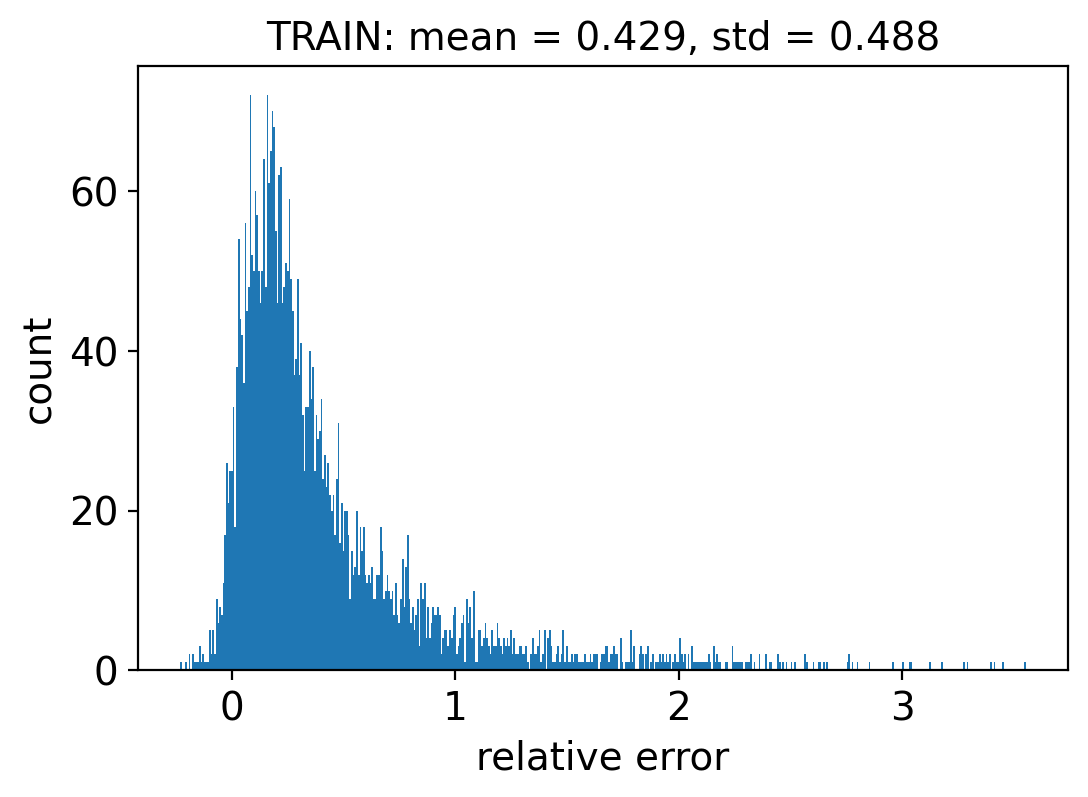

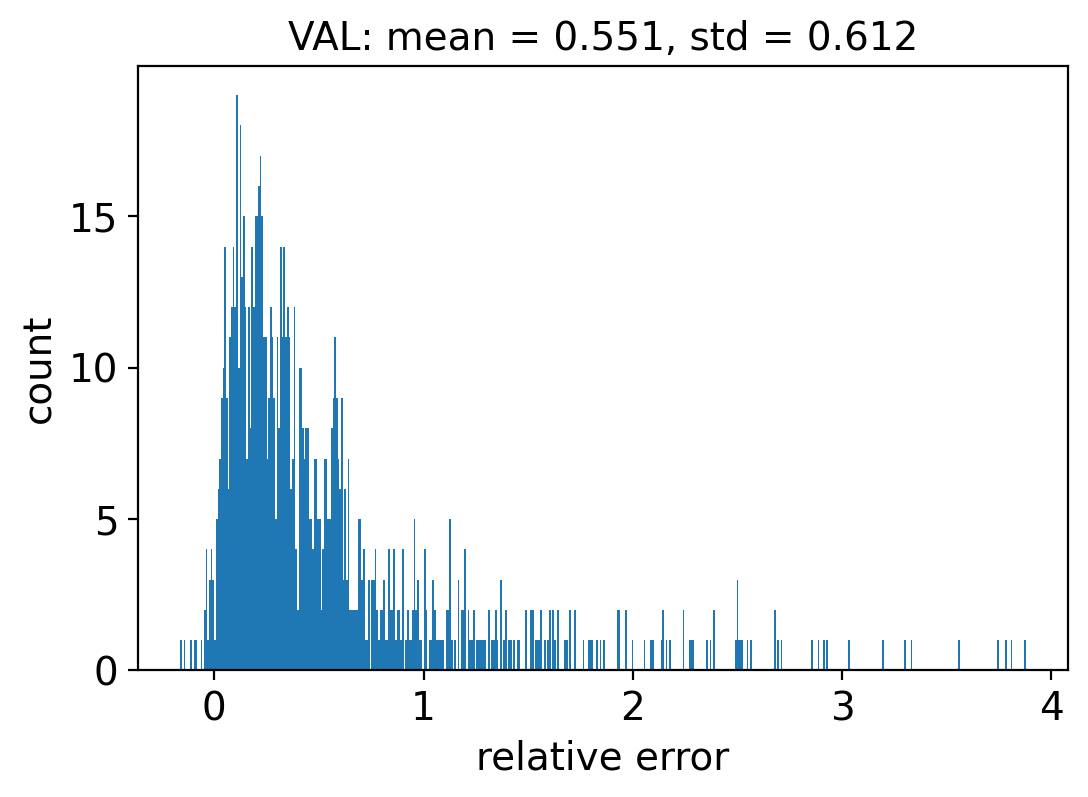

In [17]:
Model2.plot(noise_on = False, ridge = False)

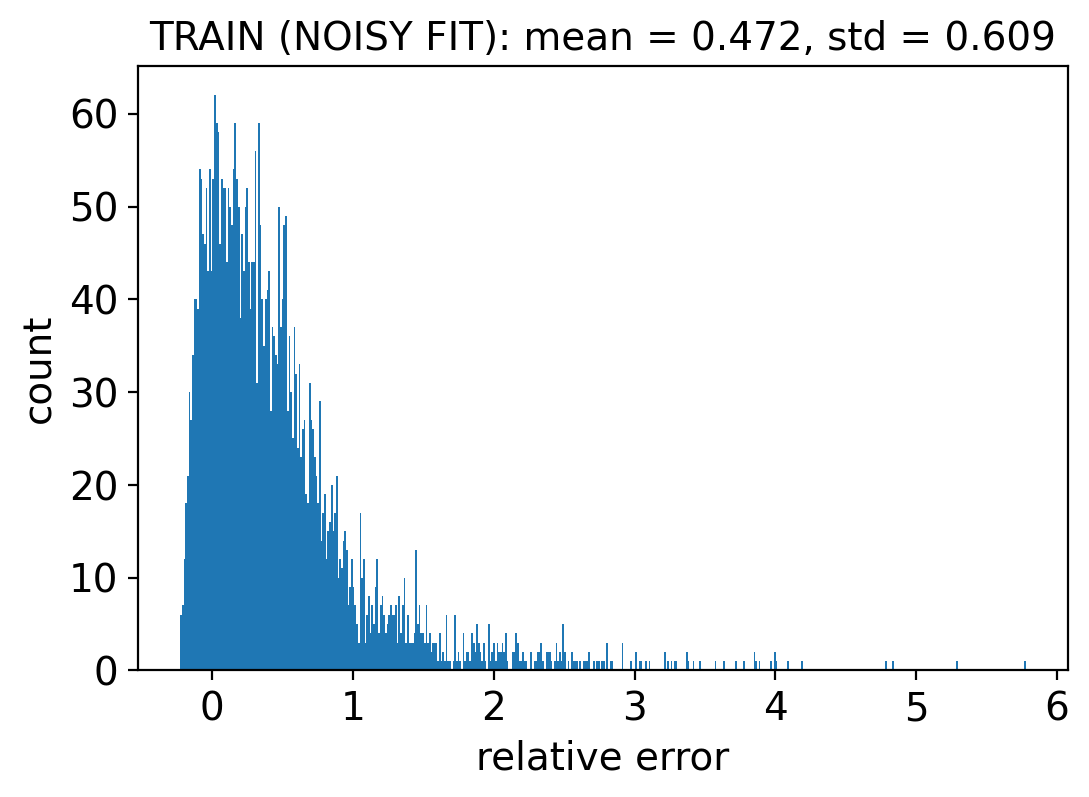

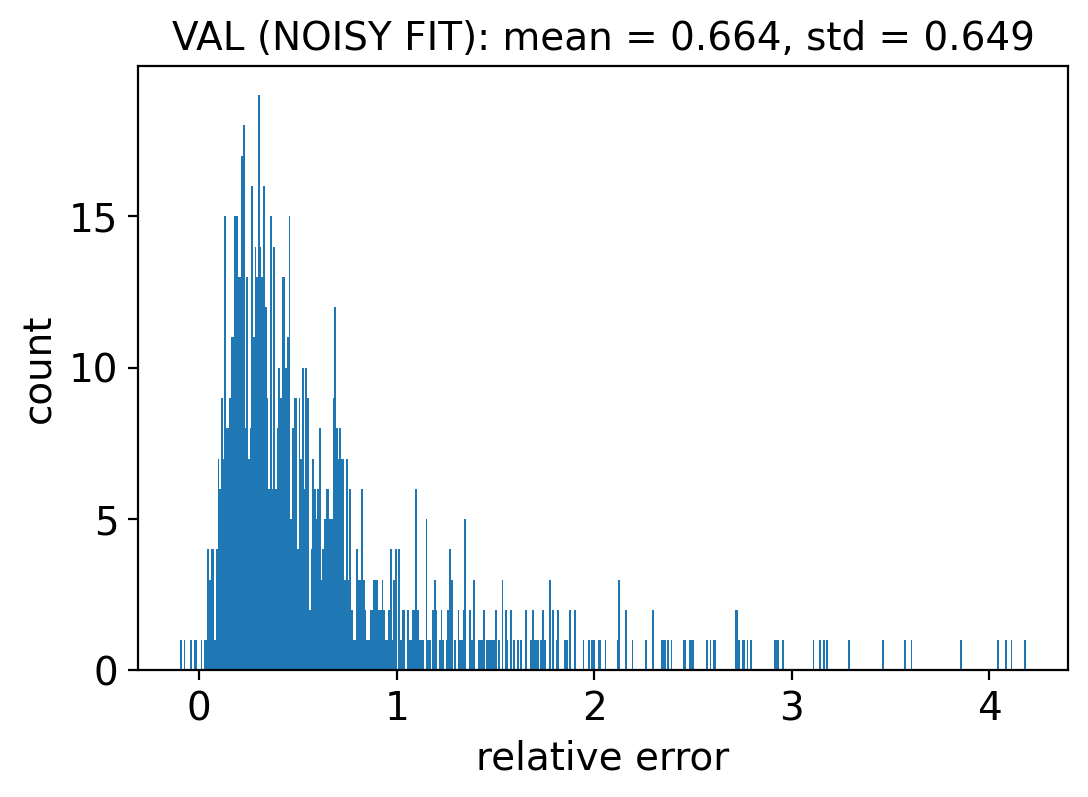

In [18]:
Model2.plot(noise_on = True, ridge = False)

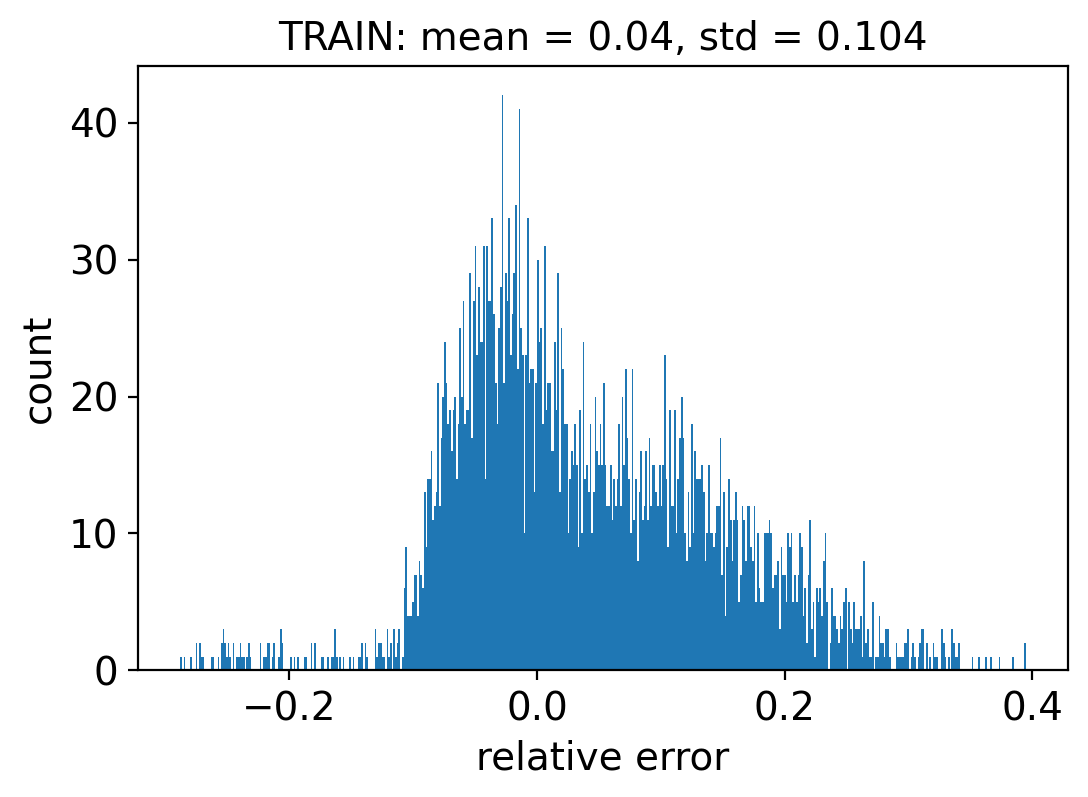

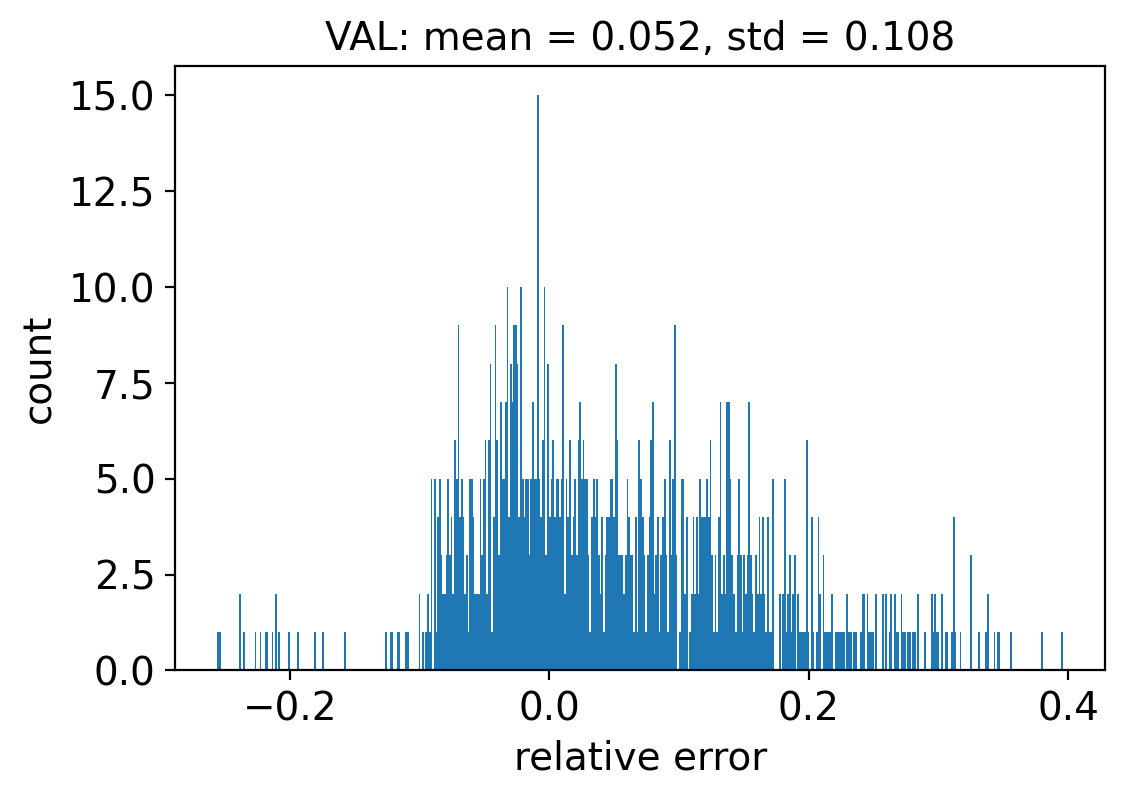

In [19]:
Model2.plot(noise_on = False, ridge = True)

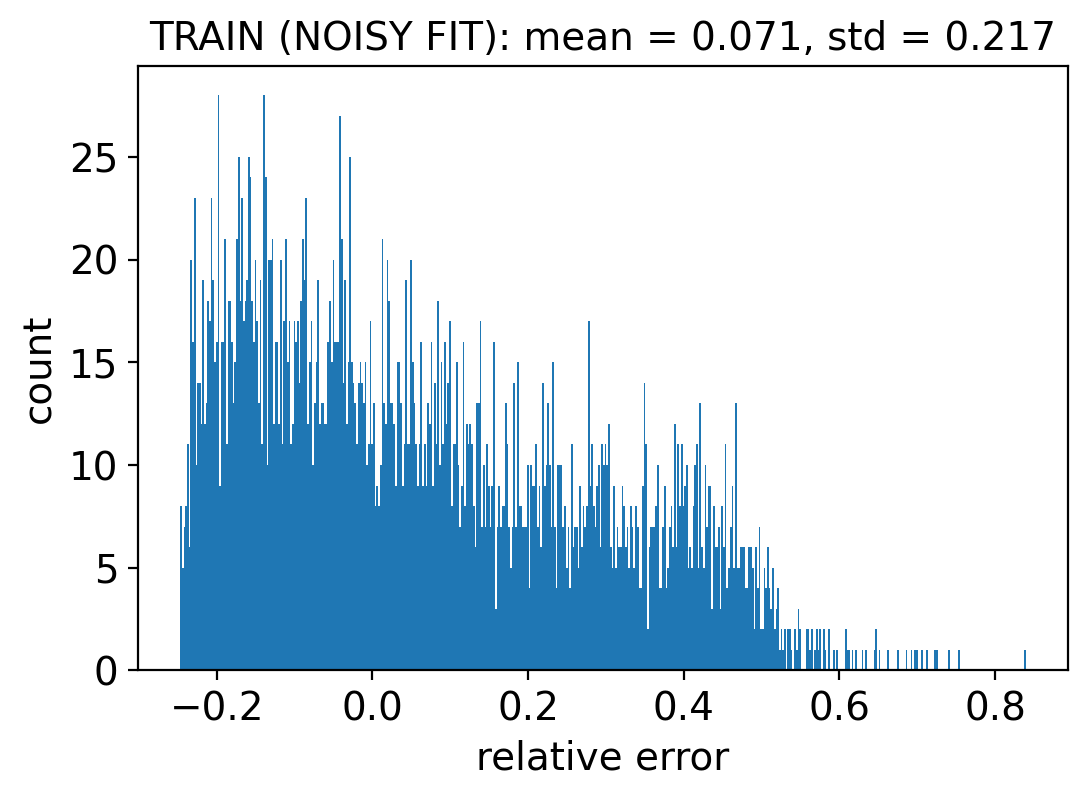

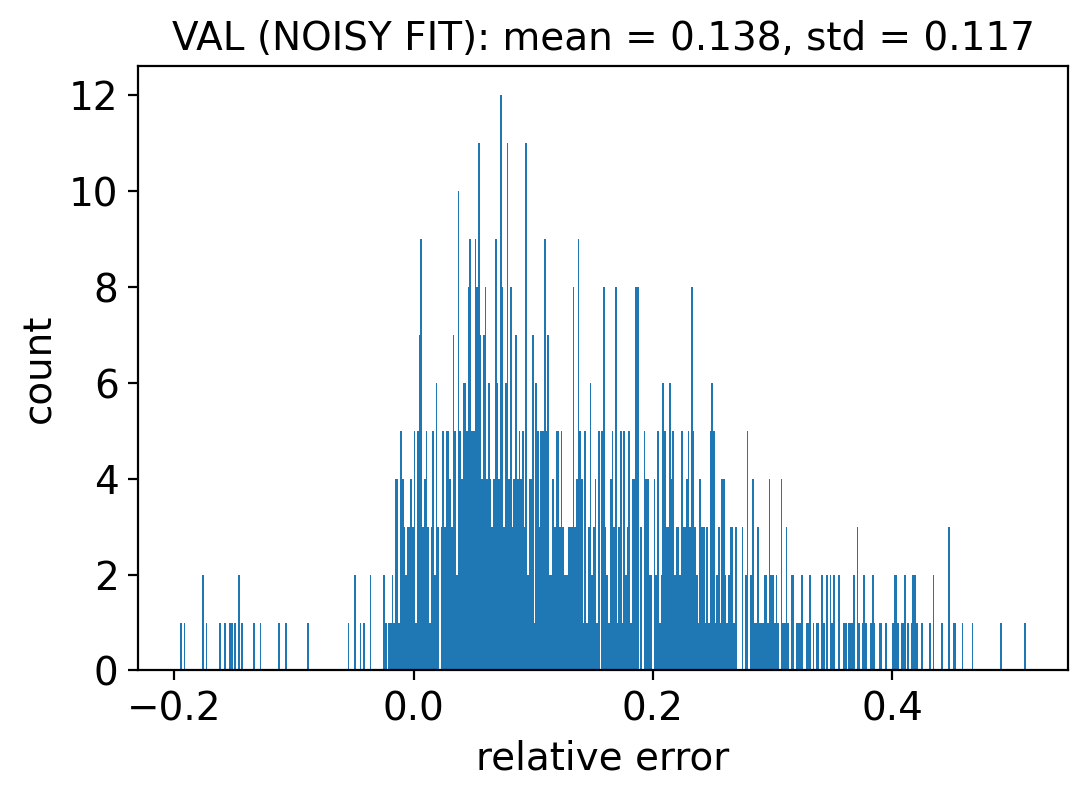

In [20]:
Model2.plot(noise_on = True, ridge = True)

In [21]:
@dataclass
class LinearRegression3:
    data_xs: np.ndarray
    data_ys: np.ndarray
    data_xs_val: np.ndarray
    data_ys_val: np.ndarray   

    def prepare_X(self, xs):
        roller = np.copy(xs)
        arrs = []
        for i in range(1, xs.shape[1]-1):
            arrs.append(xs*np.roll(roller,i, axis=1))
        ones = np.ones((xs.shape))
        X = np.stack((xs**2, *arrs, xs, ones), axis=2)
        return X
    
    def fit(self, xs, ys):
        X = self.prepare_X(xs)
        Y = np.expand_dims(ys, 1)
        A = np.tensordot(X.T, X, axes=((2,1), (0,1)))
        B = X.T@Y

        #solve
        Z = linalg.solve(A, B)
        return X,Z
    
    def fit_ridge(self, xs, ys):
        X = self.prepare_X(xs)
        Y = np.expand_dims(ys, 1)
        A = np.tensordot(X.T, X, axes=((2,1), (0,1)))
        A += 1000*np.identity(A.shape[0])
        B = X.T@Y

        #solve
        Z = linalg.solve(A, B)
        return X,Z
   
    def plot(self, noise_on = False, ridge = False):
        if noise_on == False:
            fig = plt.figure()
            if ridge == True:
                X, Z = self.fit_ridge(self.data_xs, self.data_ys)
            else:
                X, Z = self.fit(self.data_xs, self.data_ys)
            Ypred = np.tensordot(X, Z, axes=((2,1), (0,1)))
            Ytrue = np.expand_dims(self.data_ys, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'TRAIN: mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
            fig = plt.figure()
            X  = self.prepare_X(self.data_xs_val)
            Ypred = np.tensordot(X, Z, axes=((2,1), (0,1)))
            Ytrue = np.expand_dims(self.data_ys_val, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'VAL: mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
        if noise_on == True:
            fig = plt.figure()
            ys = np.random.uniform(np.min(self.data_ys), np.max(self.data_ys),self.data_ys.shape)
            if ridge == True:
                X, Z = self.fit_ridge(self.data_xs, ys)
            else:
                X, Z = self.fit(self.data_xs, ys)
            Ypred = np.tensordot(X, Z, axes=((2,1), (0,1)))
            Ytrue = np.expand_dims(ys, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'TRAIN (NOISY FIT): mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
            fig = plt.figure()
            X  = self.prepare_X(self.data_xs_val)
            Ypred = np.tensordot(X, Z, axes=((2,1), (0,1)))
            Ytrue = np.expand_dims(self.data_ys_val, 1)
            plt.hist(((Ypred-Ytrue)/Ytrue).flatten(), bins=500);
            plt.title(f'VAL (NOISY FIT): mean = {np.around(np.mean((Ypred-Ytrue)/Ytrue),3)}, std = {np.around(np.std((Ypred-Ytrue)/Ytrue),3)}', 
                      fontsize = 14)
            plt.xlabel('relative error')
            plt.ylabel('count')
            


In [22]:
Model3 = LinearRegression3(data_xs, data_ys, data_xs_val, data_ys_val)

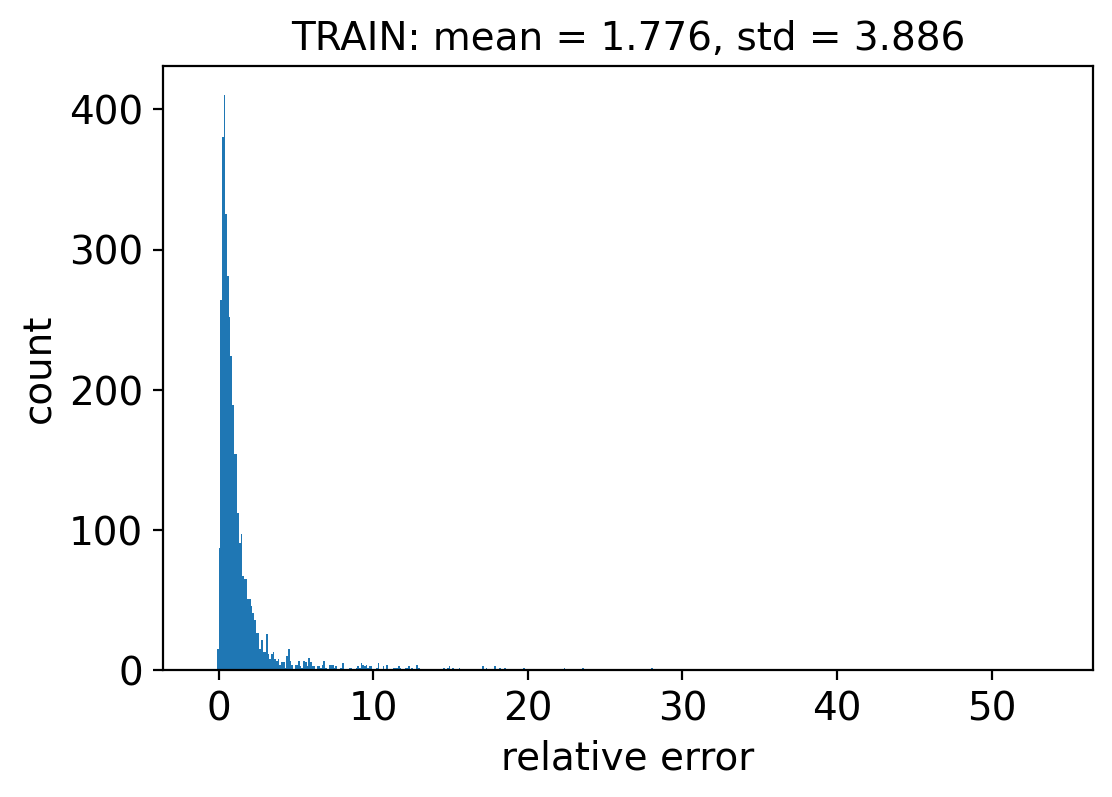

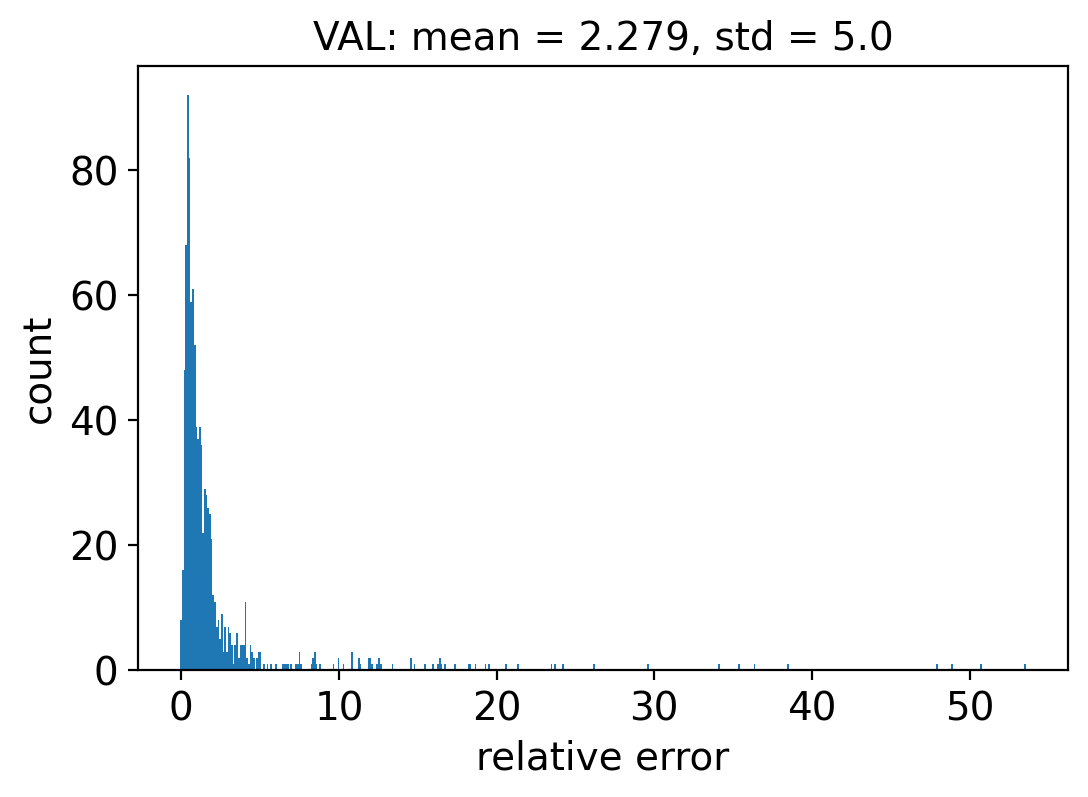

In [23]:
Model3.plot(noise_on = False, ridge = False)

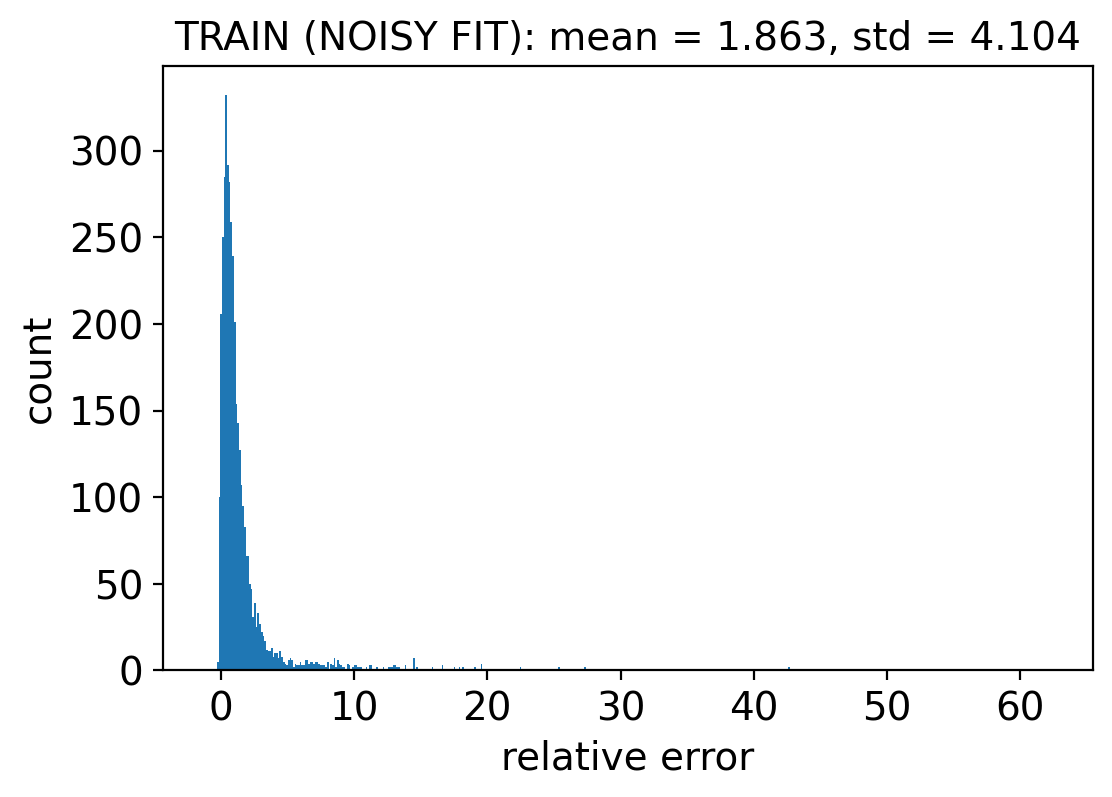

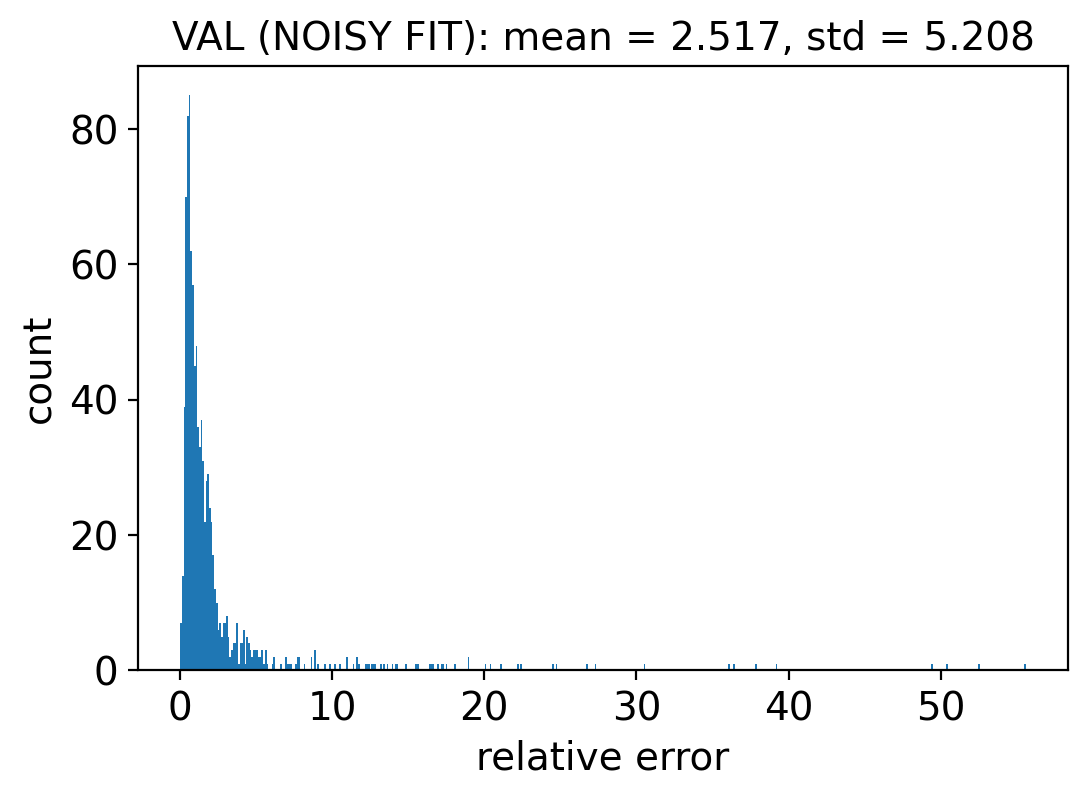

In [24]:
Model3.plot(noise_on = True, ridge = False)

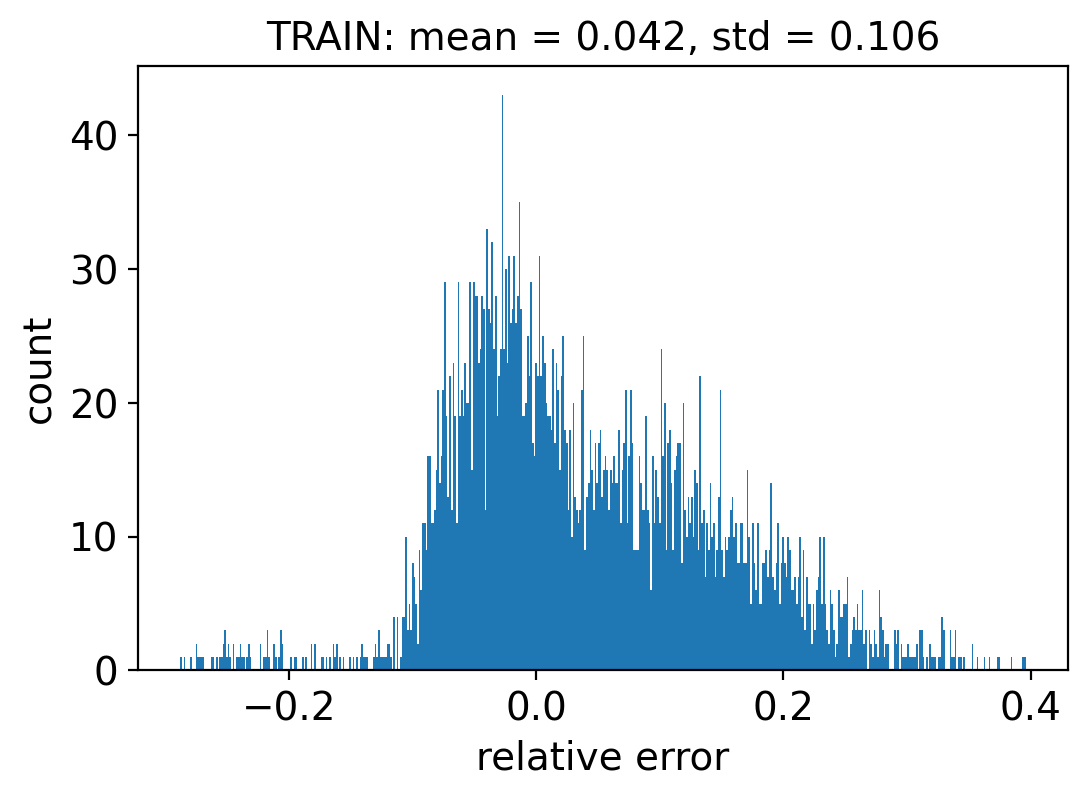

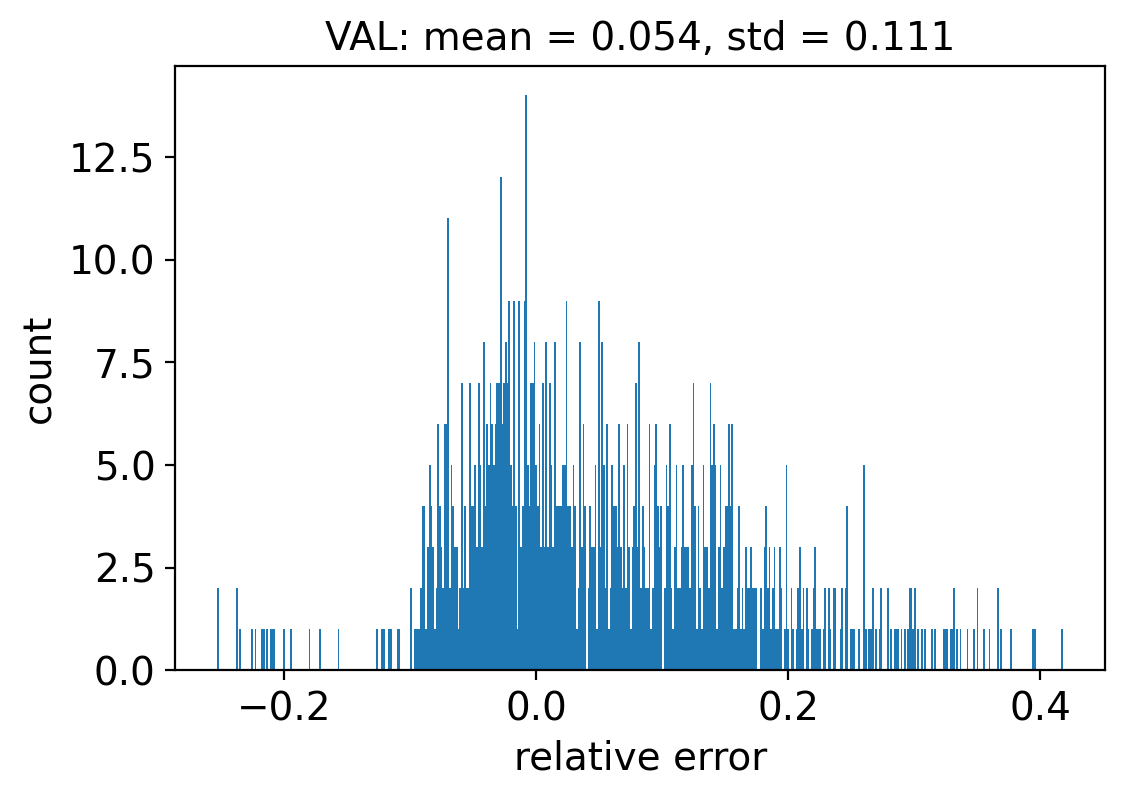

In [25]:
Model3.plot(noise_on = False, ridge = True)

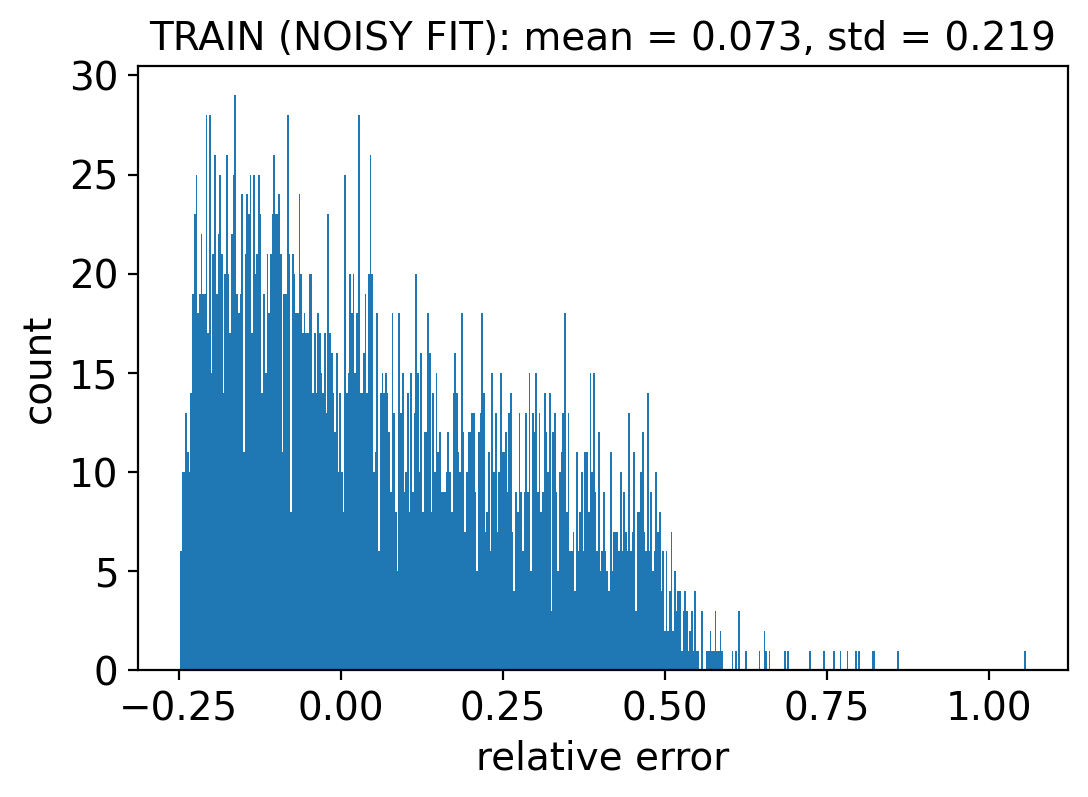

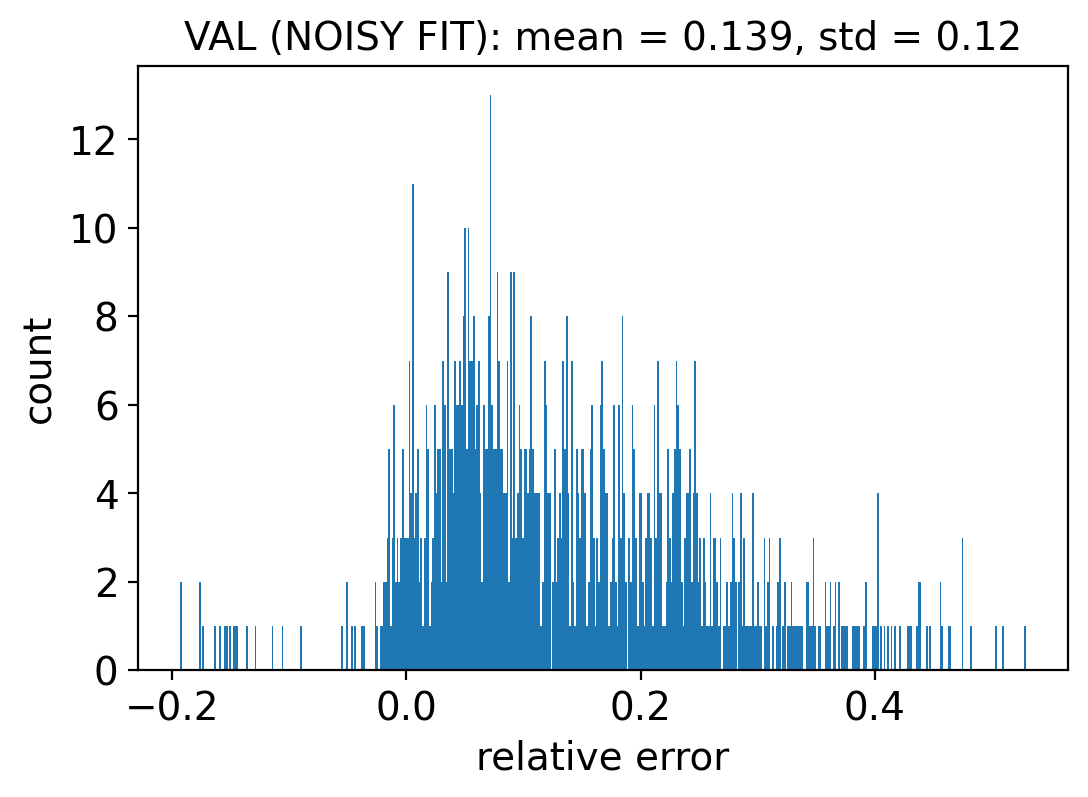

In [26]:
Model3.plot(noise_on = True, ridge = True)

#### Problem 3: Fit the famous data set 11 from Problem Set 2, but now with a single Gaussian Process. Choose as your kernel the Matern 3/2 kernel. Use the form of the GP regression shown in class, that involves both the kernel matrix K and the noise covariance C. Plot the GP result by evaluating the GP on a set of test locations which is a fine grid of spacing (say) 0.1 days over a footprint that goes from -50 days to 1075 days (ie, more than the span of the data). Plot the GP result for three different (but all reasonable) values for the Matern kernel width (the hyper-parameter). Bonus points: Plot not just the best-fit, but the uncertainty (variance) region around that fit, as per Rasmussen & Williams.

A Gaussian process can be implemented as follows:

Let $k(r_{ij})$ be the Matern 3/2 kernel function, where $r_{ij}$ denotes $|x_i-x_j|$. Let $C$ be the covariance matrix (uncertainties squared along diagonal). Then let 

### $K_* = k(|x^*_i-x_j|$

### $K_{**} = k(|x^*_i-x^*_j|$

### $K = k(|x_i-x_j|$

where star denotes the test data set.

Then the optimal label predictions for the test data set are

### $\hat{Y}^* = K_* (K+C)^{-1}Y$

and their covariance matrix is

### $\Sigma_{**} = K_{**} - K_{*}(K+C)^{-1}K_*$.

In the below I implement this GP scheme. I interpolate the original data on a narrow, uniformly spaced grid and use training data where $x \in [100, 900]$ such that the test data has a larger x-range than the test data. Note that this causes the GP to underperform in the regions where it was not trained. As the kernel width increases, the GP moves from overfitting the training data to underfitting the training data.

In [34]:
#load in the data
with open("data.pkl", "rb") as handle:
    data = pickle.load(handle).T # check out that pesky little `.T`
print(data.shape)

xs = data[0, :]
yerrs = data[1, :]
ys = data[12, :] - np.mean(data[12, :])



(13, 1024)


In [35]:
def get_r(x1, x2):
    return np.subtract.outer(x1, x2)

def matern_kernel(r, l = 1, v = 3/2):
    # see https://zhuhao.org/post/gp_python_r/
    r = np.abs(r)
    r[r == 0] = 1e-8
    part1 = 2 ** (1 - v) / gamma(v)
    part2 = (np.sqrt(2 * v) * r / l) ** v
    part3 = kv(v, np.sqrt(2 * v) * r / l)
    return part1 * part2 * part3

def GP(xs, ys, yerrs, l = 1):
    #indices = np.arange(len(xs))
    #np.random.shuffle(indices)
    #cutoff = int(len(indices)*2/3)
    #train_indices = indices[:cutoff]
    #test_indices = indices[cutoff:]
    #xs_train = xs[train_indices]
    #yerrs_train = yerrs[train_indices]
    #ys_train = ys[train_indices]
    #xs_test = xs[test_indices]
    #ys_test = ys[test_indices]
    #yerrs_test = yerrs[test_indices]
    
    xs_train_start = np.where(xs>100)[0][0]
    xs_train_end = np.where(xs>900)[0][0]
    xs_train = xs[xs_train_start:xs_train_end]
    ys_train = ys[xs_train_start:xs_train_end]
    yerrs_train = yerrs[xs_train_start:xs_train_end]
    f = interp1d(xs, ys)
    xs_test = np.arange(np.min(xs), np.max(xs), 0.1)
    ys_test = f(xs_test)
    
    C_train = np.zeros((len(xs_train), len(xs_train)))
    np.fill_diagonal(C_train, yerrs_train**2)
    Y_train = np.expand_dims(ys_train, axis=1)
    
    K = matern_kernel(get_r(xs_train, xs_train), l=l)
    Kstar = matern_kernel(get_r(xs_test, xs_train), l=l)
    Kstarstar = matern_kernel(get_r(xs_test, xs_test), l=l)
    Ystar = Kstar@(np.linalg.inv(K+C_train))@Y_train
    Sigmastarstar = Kstarstar - Kstar@(np.linalg.inv(K+C_train))@Kstar.T
    X_test = np.expand_dims(xs_test, axis=1)
    Y_test =  np.expand_dims(ys_test, axis=1)
    
    fig = plt.figure()
    sort = np.argsort(X_test[:,0])
    plt.errorbar(X_test[sort].flatten(), Ystar[sort].flatten(), yerr = np.sqrt(np.diag(Sigmastarstar))[sort].flatten(), 
                 marker = '.', color = 'deeppink', linestyle = 'None', label = 'predict')
    plt.plot(X_test[sort], Y_test[sort], marker = '.', color = 'black', linestyle = 'None', zorder = -1, 
             label = 'true')
    plt.xlabel('x')
    plt.ylabel('y(x)')
    plt.legend()
    

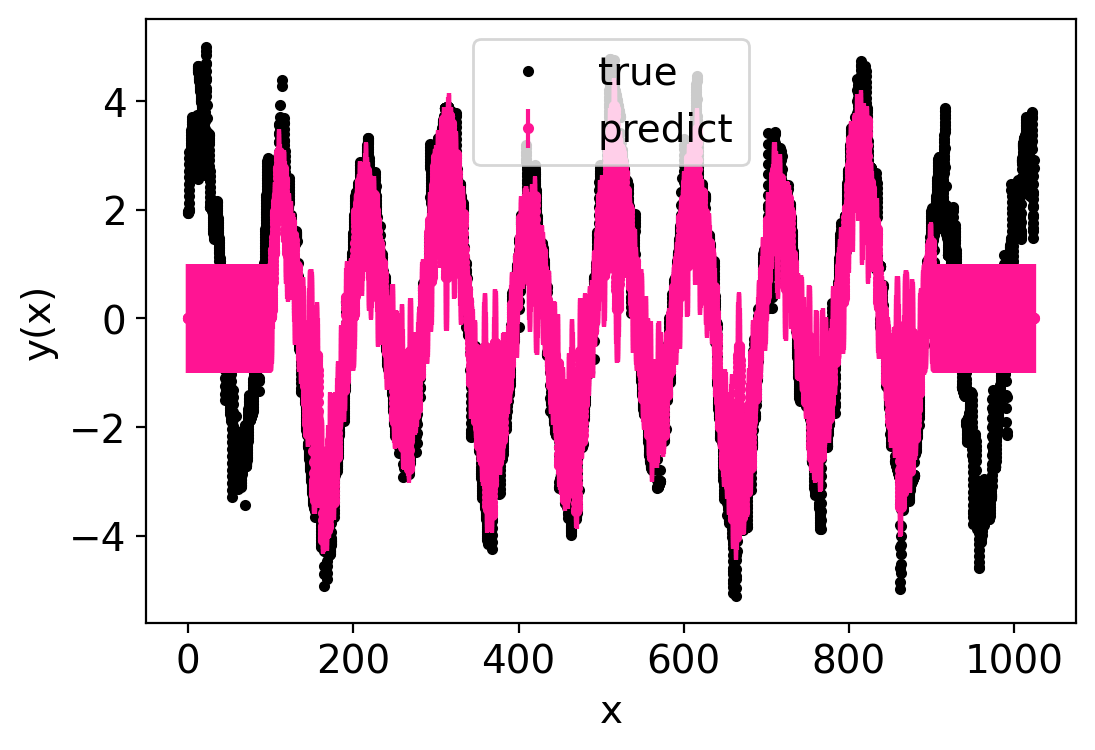

In [36]:
GP(xs, ys, yerrs, l = 1)

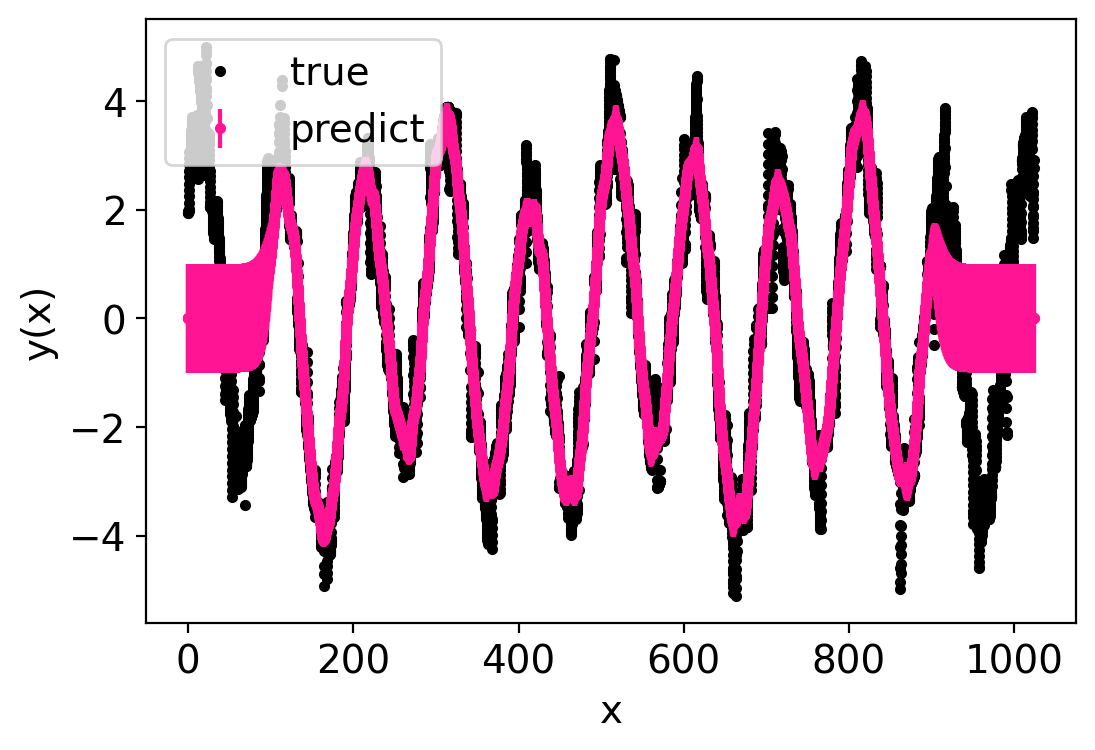

In [37]:
GP(xs, ys, yerrs, l = 10)

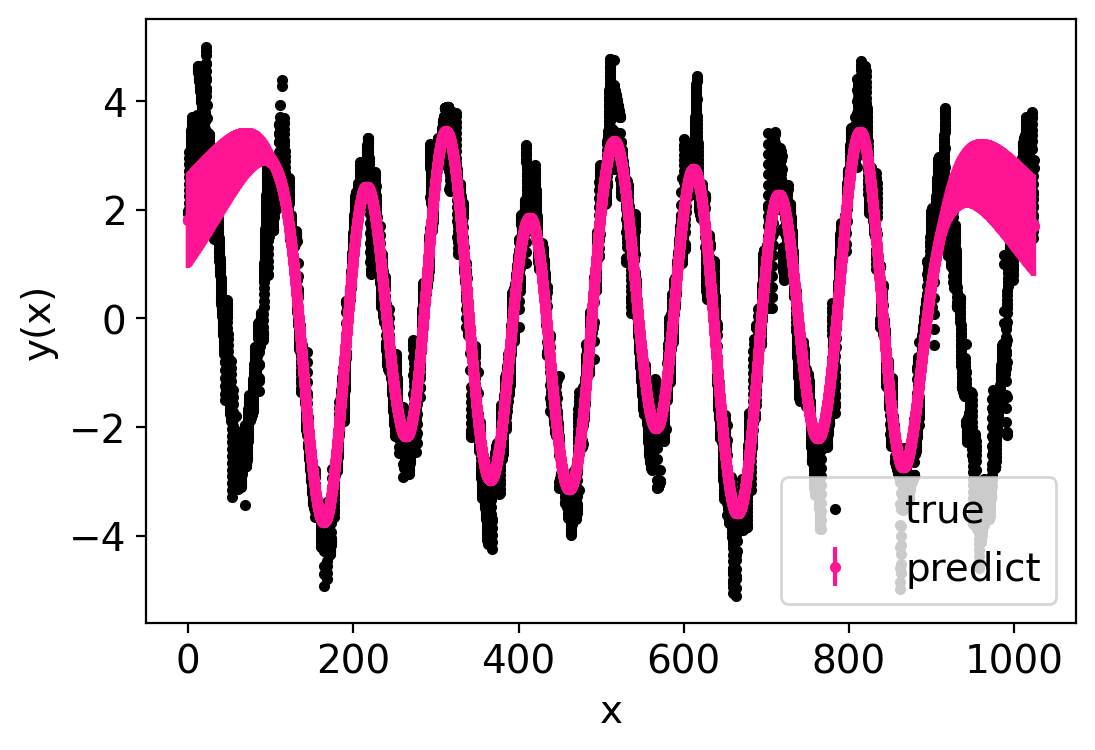

In [38]:
GP(xs, ys, yerrs, l = 100)

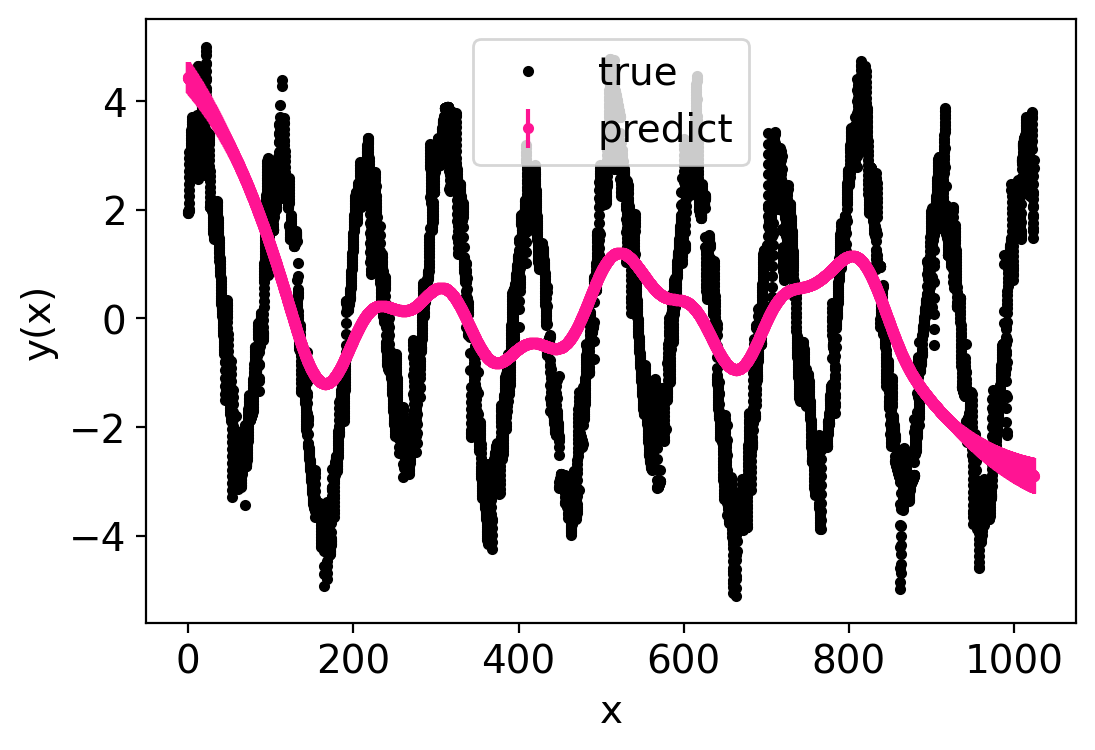

In [39]:
GP(xs, ys, yerrs, l = 500)